# S&P 500 Market Data

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
from datetime import timedelta as td
import seaborn as sns
import quandl

# Quandle API key
quandle_api_key_file = "quandl_api_key_file"
f = open(quandle_api_key_file,'r')
quandl_api_key=f.read().strip()
f.close

# Fred API key
fred_api_key_file = "fred_api_key_file"
f = open(fred_api_key_file,'r')
fred_api_key=f.read().strip()
f.close

<function TextIOWrapper.close()>

# Contents
**Step 1. Data Import** - S&P500, T10Y3M, GDP, UNRATE, CPI, UMCSENT, SP500 PE Ratio  
**Step 2. Market Cycles**  
**Step 3. Join & Transform** - GSPC, T10Y3M, GDP, UNRATE, CPI, UMCSENT, Momentum & ADX, Volatility, SP PE   
**Step 4. ML DataFrame**  
**Step 5. Correlate & Heatmap**  
**Step 6. Save the ML data frame**

# Step 1. Data Import


<table>
    <caption><center><strong>Table 1. Data and Sources </strong></center></caption>
    <tr>
     <td width="10%" style="text-align:left;vertical-align:center;" ><strong>Data</strong></td>
     <td width="20%" style="text-align:left;vertical-align:center;" ><strong>Source</strong></td>
     <td width="10%" style="text-align:left;vertical-align:center;" ><strong>Frequency</strong></td>
     <td width="10%" style="text-align:left;vertical-align:center;" ><strong>Start Date</strong></td>
    </tr>
     <tr>
        <td style="text-align:left;vertical-align:top;" >
          S&P 500
        </td>
        <td style="text-align:left;vertical-align:top;" >
          Yahoo Finance ^GSPC
         </td>
        <td style="text-align:left;vertical-align:top;" >
          Daily
        </td>
       <td style="text-align:left;vertical-align:top;" >
          1950-1-3
        </td>
      </tr>
     <tr>
        <td style="text-align:left;vertical-align:top;" >
          Recessions
        </td>
        <td style="text-align:left;vertical-align:top;" >
          Wikepedia (entered into a Pyquant callable function), pyquant.get_ressions()
         </td>
        <td style="text-align:left;vertical-align:top;" >
          Recessions function updated when there is recessions (usually many years between recessions)
        </td>
       <td style="text-align:left;vertical-align:top;" >
          1950
        </td>
      </tr>
     <tr>
     <td style="text-align:left;vertical-align:top;" >
         Yield Curve 10 year (long term) fixed rate vs. 3 month (short term) rates.
      </td>
        <td style="text-align:left;vertical-align:top;" >
          FRED St. Louis, T10Y3M
         </td>
        <td style="text-align:left;vertical-align:top;" >
          Daily
        </td>
       <td style="text-align:left;vertical-align:top;" >
          1982-1-4
        </td>
      </tr>
         <tr>
     <td style="text-align:left;vertical-align:top;" >
         Gross Domestic Product 
      </td>
        <td style="text-align:left;vertical-align:top;" >
          FRED St. Louis, GDP
         </td>
        <td style="text-align:left;vertical-align:top;" >
          Quarterly
        </td>
        <td style="text-align:left;vertical-align:top;" >
          1947-1-1
        </td>
      </tr>
     <tr>
       <td style="text-align:left;vertical-align:top;" >
         Unemployment Rate 
        </td>
        <td style="text-align:left;vertical-align:top;" >
          FRED St. Louis, UNRATE
         </td>
        <td style="text-align:left;vertical-align:top;" >
          Monthly
        </td>
          <td style="text-align:left;vertical-align:top;" >
          1948-1-1
        </td>
        </tr>
         <tr>
       <td style="text-align:left;vertical-align:top;" >
         Consumer Price Index 
        </td>
        <td style="text-align:left;vertical-align:top;" >
          FRED St. Louis, CPIAUCSL, 1982to1984 100% 
         </td>
        <td style="text-align:left;vertical-align:top;" >
          Monthly
        </td>
         <td style="text-align:left;vertical-align:top;" >
          1947-1-1
        </td>
        </tr>
        <tr>
       <td style="text-align:left;vertical-align:top;" >
         Consumer Sentiment
        </td>
        <td style="text-align:left;vertical-align:top;" >
          FRED St. Louis,UMCSENT 
         </td>
        <td style="text-align:left;vertical-align:top;" >
          Monthly
        </td>
         <td style="text-align:left;vertical-align:top;" >
         1953-2-1
        </td>
      </tr>
</table>

####  S&P 500

In [4]:
%run fmfunctions

# Notebook Parameters
#test_s = dt.datetime(2016,1,1)      # 2016 for daily predictions, 2000, 1970, 1960
#dataStartDate=dt.datetime(1950,1,1) # 2014 for daily updates, 1950 for long term updates
#train_s = dt.datetime(1950,1,1)
today = dt.datetime.today()
#test_e = dt.datetime(today.year,today.month,today.day)
#test_e = dt.datetime(2017,4,8)
#print("dataStartDate = ",dataStartDate,'\ntest_s = ',test_s,'\ntest_e = ',test_e)

# Read in S&P 500 Data
dfsp500 = pd.read_csv('./data/GSPC_1950-1-3_to_2020-8-24.csv',index_col=0,parse_dates=True)


# Get new data
get_new = False

if get_new == True:
    start=dt.datetime(2020,8,1)
    end=dt.datetime(2020,8,25) # note, this always gives one day back from the last date requested
    dfsp500=yfgetappend('^GSPC',start,end,df=dfsp500,save=True,savedir='./data')
    
dfsp500.tail(3)

,Close,High,Low,Open,Volume,Adj Close
Date,,,,,,
2020-08-20,3385.510010,3390.800049,3354.689941,3360.479980,3.642850e+09,3385.510010
2020-08-21,3397.159912,3399.959961,3379.310059,3386.010010,3.705420e+09,3397.159912
2020-08-24,3431.280029,3432.090088,3413.129883,3418.090088,3.728690e+09,3431.280029


### Recessions

In [247]:
# Recession Data
# get recessions and put in dataframe to make it look pretty
%run fmfunctions
recessions = get_recessions()
dfrecessions = pd.DataFrame(data=recessions)
dfrecessions.columns=['start','end']
display(dfrecessions)

,start,end
0,1953-07-01,1954-05-01
1,1957-07-01,1958-04-01
2,1960-04-01,1961-02-01
3,1969-12-01,1970-11-01
4,1973-11-01,1975-03-01
5,1980-01-01,1980-07-01
6,1981-07-01,1982-11-01
7,1990-07-01,1991-03-01
8,2001-03-01,2001-11-01
9,2007-12-01,2009-06-01


In [107]:
# SP PE Ratio Quandl

# DESCRIPTION
# Price to earnings ratio, based on trailing twelve month as reported earnings. 
# Current PE is estimated from latest reported earnings and current market price. 
# Source: Robert Shiller and his book Irrational Exuberance for historic S&P 500 PE Ratio.
# note S&P reports https://www.multpl.com/s-p-500-earnings/table/by-month ... seems to be 
#   reported monthly, except when there are disruptions such as COVID on Oct 5 last report is
#   Mar 31 2020
#   https://www.multpl.com/s-p-500-earnings/table/by-month
# Though S&P offers earnings directly, the terms are stringent, so best to get SP PE from Quandl
# Quandl: Financial, Economic, and Alternative data sets
#   conda install quandl
#   data = quandl.get("FRED/GDP", start_date="2001-12-31", end_date="2005-12-31")
#   quandl.get("MULTPL/SP500_PE_RATIO_MONTH", authtoken="aZbq-NeDus7sPMkcAFs_")
#   quandl_api_key = "aZbq-NeDus7sPMkcAFs_"
# https://www.guru99.com/reading-and-writing-files-in-python.html



In [131]:
# SP 500 PE Ratio
%run fmfunctions
sppe_filename='./data/sp500_pe_daily_1950-1-3_to_2020-8-24.csv'

df_sppe_daily =pd.read_csv(sppe_filename,index_col=0,parse_dates=True)

get_sppe_quandl=False
if get_sppe_quandl==True:
    start='2020-7-1'
    end='2020-10-1'
    savedir='./data'
    save=True
    df_sppe_daily=quandl_sppegetappend(df_sppe_daily,dfsp500,quandl_api_key,
                                       start,end,save=save, savedir=savedir)
    
display(df_sppe_daily.head())
display(df_sppe_daily.tail())

,PE,Earnings
Date,,
1950-01-03,NaN,NaN
1950-01-04,NaN,NaN
1950-01-05,NaN,NaN
1950-01-06,NaN,NaN
1950-01-09,NaN,NaN


,PE,Earnings
Date,,
2020-08-18,29.140053,116.327173
2020-08-19,29.011709,116.327173
2020-08-20,29.103346,116.327173
2020-08-21,29.203494,116.327173
2020-08-24,29.496806,116.327173


#### Yield Curve

In [248]:
# Yield Curve
%run fmfunctions

start='2020-08-01'
end='2020-08-31'
filename='./data/T10Y3M_1982-1-4_to_2020-8-24.csv'
dft10y3m =pd.read_csv(filename,index_col=0,parse_dates=True)


get_FredYield=False
if get_FredYield == True:
    Series='T10Y3M'
    dft10y3m=fredSeries(Series,start,end,df=dft10y3m,API_KEY_FRED=fred_api_key,save=True,savedir='./data')

display(dft10y3m.tail(5))

,T10Y3M
index,
2020-08-18,0.58
2020-08-19,0.57
2020-08-20,0.54
2020-08-21,0.54
2020-08-24,0.53


#### Get GDP

In [249]:
%run fmfunctions

start='2020-01-01'
end='2020-08-31'
filename='./data/GDP_1947-1-1_to_2020-4-1.csv'
dfgdp = pd.read_csv(filename,index_col=0,header=0,parse_dates=True)

get_FredGDP = False
if get_FredGDP == True:
    Series='GDP'
    dfgdp=fredSeries(Series,start,end,df=dfgdp,API_KEY_FRED=fred_api_key,save=True,savedir='./data')

display(dfgdp.tail(5))

,GDP
index,
2019-04-01,21340.267
2019-07-01,21542.540
2019-10-01,21729.124
2020-01-01,21561.139
2020-04-01,19408.759


#### Unemployment

In [250]:
# Unemployment and Consumer Price Index
# UNRATE monthly
%run fmfunctions

start='2020-01-01'
end='2020-08-31'

filename='./data/UNRATE-1948-1-1_to_2020-7-1.csv'
dfunrate = pd.read_csv(filename,index_col=0,header=0,parse_dates=True)

# https://fred.stlouisfed.org/series/CPIAUCSL   1982to1984_100percent
getFred_UNRATE=False
if getFred_UNRATE==True:
    Series='UNRATE'
    dfunrate=fredSeries(Series,start,end,df=dfunrate,API_KEY_FRED=fred_api_key,save=True,savedir='./data')
display(dfunrate.tail(5))


,UNRATE
DATE,
2020-03-01,4.4
2020-04-01,14.7
2020-05-01,13.3
2020-06-01,11.1
2020-07-01,10.2


### Consumer Price Index

In [251]:
# CPI
# Monthly
filename='./data/CPIAUCSL-1947-1-1_to_2020-7-1.csv'
dfcpiaucsl = pd.read_csv(filename,index_col=0,header=0,parse_dates=True)

getFred_CPI=False
if getFred_CPI==True:
    Series='cpiaucsl'
    dfcpiaucsl=fredSeries(Series,start,end,df=dfcpiaucsl,API_KEY_FRED=fred_api_key,save=True,savedir='./data')

display(dfcpiaucls.tail(5))

,CPIAUCSL
DATE,
2020-03-01,257.953
2020-04-01,255.902
2020-05-01,255.768
2020-06-01,257.214
2020-07-01,258.723


#### Consumer Sentiment

In [252]:
# Get Consumer Sentiment
# Monthly

%run fmfunctions

start='2020-1-1'
end='2020-8-31'

filename='./data/UMCSENT-1953-2-1_to_2020-3-1.csv'
dfumcsent = pd.read_csv(filename,index_col=0,header=0,parse_dates=True)

# https://fred.stlouisfed.org/series/CPIAUCSL   1982to1984_100percent
getFred_UMCSENT=False
if getFred_UMCSENT==True:
    Series='UMCSENT'
    dfunrate=fredSeries(Series,start,end,df=dfumcsent,API_KEY_FRED=fred_api_key,save=True,savedir='./data')
display(dfunrate.tail(5))

,UNRATE
DATE,
2020-03-01,4.4
2020-04-01,14.7
2020-05-01,13.3
2020-06-01,11.1
2020-07-01,10.2


# Step 2. Market Cycles

In [656]:
#Market Cycles

%run fmcycle
compute=0   # if compute is 1 then compute new market cycles, else load from saved file

f_dfmc="./data/GSPC_dfmc2020.5_1950_2020-8-24.csv"
f_dfmcs="./data/GSPC_dfmcs2020.5_1950_2020-8-24.csv"

mcycledown=20
mcycleup=20.5

#string = get_market_cycles()

dfmc,dfmcsummary=fmcycles(df=dfsp500,symbol='GSPC',compute=compute, mc_filename=f_dfmc, mcs_filename=f_dfmcs,
                 mcdown_p=mcycledown,mcup_p=mcycleup,savedir="./data")


compute ==0, read from file ...
  dfmc filename =  ./data/GSPC_dfmc2020.5_1950_2020-8-24.csv
  dfmcs filename =  ./data/GSPC_dfmcs2020.5_1950_2020-8-24.csv
mcdown = 20 mcup = 20.5


In [520]:
# https://seekingalpha.com/article/4199997-historical-bull-and-bear-markets-of-s-and-p-500

dfmcsummary

,mkt,startTime,endTime,startPrice,endPrice,mcnr
1950-01-03,1.0,1950-01-03,1956-08-02,16.660000,49.639999,1.979592
1956-08-02,-1.0,1956-08-02,1957-10-22,49.639999,38.980000,-0.214746
1957-10-22,1.0,1957-10-22,1961-12-12,38.980000,72.639999,0.863520
1961-12-12,-1.0,1961-12-12,1962-06-26,72.639999,52.320000,-0.279736
1962-06-26,1.0,1962-06-26,1966-02-09,52.320000,94.059998,0.797783
1966-02-09,-1.0,1966-02-09,1966-10-07,94.059998,73.199997,-0.221773
1966-10-07,1.0,1966-10-07,1968-11-29,73.199997,108.370003,0.480465
1968-11-29,-1.0,1968-11-29,1970-05-26,108.370003,69.290001,-0.360616
1970-05-26,1.0,1970-05-26,1973-01-11,69.290001,120.239998,0.735315
1973-01-11,-1.0,1973-01-11,1974-10-03,120.239998,62.279999,-0.482036


In [318]:
dfmc.tail(5)

,Close,High,Low,Open,Volume,Adj Close,mkt,mchlm,newmhlm,sdm,mcupm,mcnr,mucdown,mdcup,mcudthr,muchp,mdclp,dfhlm
Date,,,,,,,,,,,,,,,,,,
2020-08-18,3389.780029,3395.060059,3370.149902,3387.040039,3.881310e+09,3389.780029,1,NaN,1,0,1,0.515053,0.000000,0.0,2711.824023,0.232656,0.0,0.0
2020-08-19,3374.850098,3399.540039,3369.659912,3392.510010,3.884480e+09,3374.850098,1,NaN,0,0,1,0.508380,0.004404,0.0,2711.824023,0.227227,0.0,0.1
2020-08-20,3385.510010,3390.800049,3354.689941,3360.479980,3.642850e+09,3385.510010,1,NaN,0,0,1,0.513145,0.001260,0.0,2711.824023,0.231104,0.0,0.2
2020-08-21,3397.159912,3399.959961,3379.310059,3386.010010,3.705420e+09,3397.159912,1,NaN,1,0,1,0.518352,0.000000,0.0,2717.727930,0.235340,0.0,0.0
2020-08-24,3431.280029,3432.090088,3413.129883,3418.090088,3.728690e+09,3431.280029,1,NaN,1,0,1,0.533602,0.000000,0.0,2745.024023,0.247747,0.0,0.0


### Plot Market Cycle

In [652]:
# Bear Market and Recession Annotations

# Bear Market Annotations
# https://www.foxbusiness.com/markets/history-of-bear-markets-since-1929
# https://www.marottaonmoney.com/the-golden-bear-the-bear-market-of-1973/
# https://www.marottaonmoney.com/the-dot-com-bubble-the-bear-market-of-2001/
# http://www.nbcnews.com/id/37740147/ns/business-stocks_and_economy/t/historic-bear-markets/#.X1k--RPYrUI
bearannotations=[]
bearannotations.append((dt.datetime(1956,1,1),-1.1,'1956-57\nRed\nScare'))
bearannotations.append((dt.datetime(1961,1,1),-1.3,'1961-62\nSteel &\nTech\nCrash'))
bearannotations.append((dt.datetime(1965,4,1),-1.1,'1966\nCredit\nCrunch'))
bearannotations.append((dt.datetime(1969,4,1),-1.3,'1968-70\nDouble\nBottom\nBear'))
bearannotations.append((dt.datetime(1974,1,1),-1.1,'1973-74\nGolden\nBear'))
bearannotations.append((dt.datetime(1981,1,1),-1.1,'1980-82\nVolker\nBear'))
bearannotations.append((dt.datetime(1987,1,1),-1.1,'1987 Oct\nBlack\nMonday'))
bearannotations.append((dt.datetime(2000,1,1),-1.1,'2000-02\nDot Com\nBubble'))
bearannotations.append((dt.datetime(2007,1,1),-1.2,'2007-09\nFinancial\nCrisis'))
bearannotations.append((dt.datetime(2019,1,1),-1.1,'2020\nCOVID\nBear'))

# https://www.investopedia.com/articles/economics/08/past-recessions.asp
# Recession Annotations
recessionannotations=[]
recessionannotations.append((dt.datetime(1951,1,1),2.8,'1953-54\nPost\nKorean\nWar\nRecession','k'))
recessionannotations.append((dt.datetime(1956,1,1),3.8,'1957-58\nEisenhower\nRecession','k'))
recessionannotations.append((dt.datetime(1959,1,1),2.5,'1960-61\nRolling\nAdjustment\nRecession','k'))
recessionannotations.append((dt.datetime(1969,1,1),3.2,'1969-70\nNixon\nRecession','k'))
recessionannotations.append((dt.datetime(1973,1,1),2,'1973-75\nOil\nCrisis\nRecession','k'))
recessionannotations.append((dt.datetime(1978,1,1),3.8,'1980\nEnergy\nCrisis\nRecession','k'))
recessionannotations.append((dt.datetime(1981,1,1),2.5,'1981-82\nIran\nEnergy\nCrisis\nRecession','k'))
recessionannotations.append((dt.datetime(1990,1,1),2.8,'1990-91\nGulf\nWar\nRecession','k'))
recessionannotations.append((dt.datetime(2001,1,1),2.8,'2001\n9/11\nRecession','k'))
recessionannotations.append((dt.datetime(2007,1,1),2.8,'2007-09\nThe\nGreat\nRecession','k'))
recessionannotations.append((dt.datetime(2018,1,1),4.2,'2020\nCOVID-19\nRecession','k'))

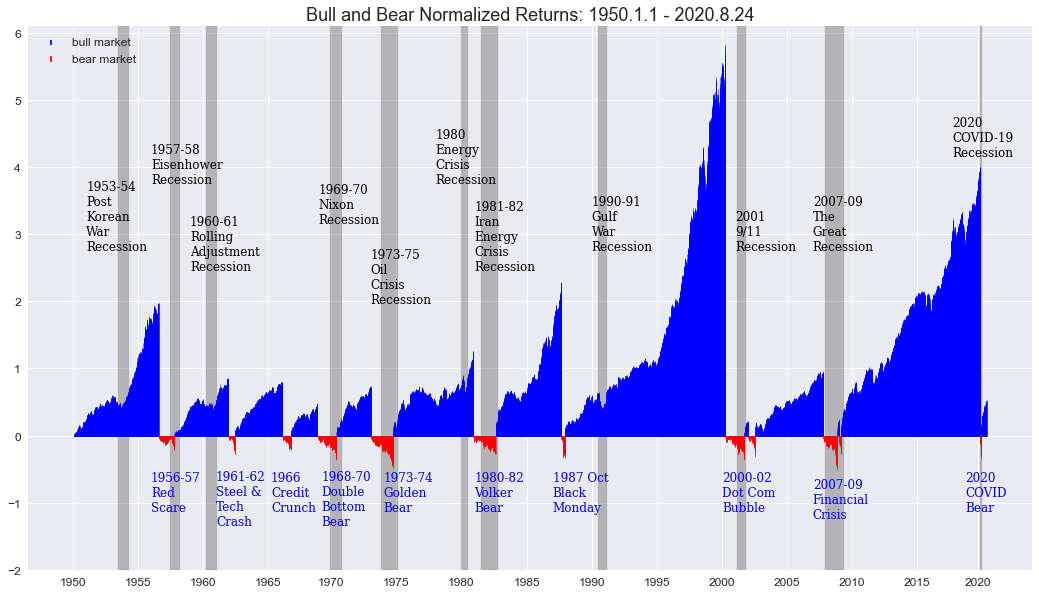

In [655]:
%run fmfunctions
%run fmplot

enddate=test_e
startdate=dt.datetime(1950,1,1)
enddate=dt.datetime(2020,8,24)

#startdate=dt.datetime(2007,2,1)
#enddate=dt.datetime(2020,8,1)


title=['Bull and Bear Normalized Returns']
variables=['mcnr']
fmplot(dfmc,variables,titles=title,startdate=startdate,enddate=enddate,fb=recessions,
          plottypes=['mktcycle'], stemlw=0.5, ylims=(-2,6.1),
          titlein=False, figsize=(18,10),titledate=True, title_fontsize=18,
          annotations=[bearannotations + recessionannotations])



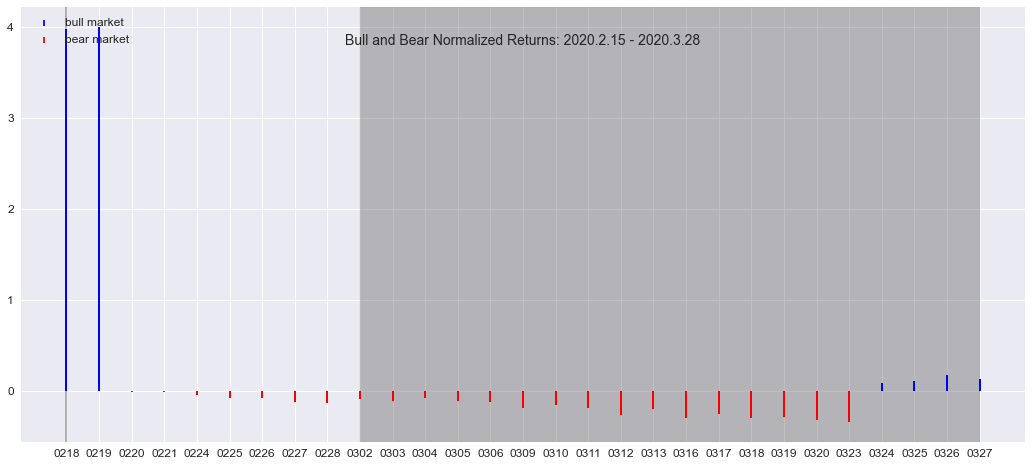

In [553]:
%run fmfunctions
%run fmplot


startdate=dt.datetime(2020,2,15)
enddate=dt.datetime(2020,3,28)

#plotmc(dfmc,'mcnr',stemlw=2)
#plot_mktcycle(dfmc,'mcnr',startdate=startdate,enddate=enddate,stemlw=2,
#              fb=recessions)

title=['Bull and Bear Normalized Returns']
variables=['mcnr']
fmplot(dfmc,variables,titles=title,startdate=startdate,enddate=enddate,stemlw=2,fb=recessions,
          plottypes=['mktcycle'], 
          titlein=True, figsize=(18,8),titledate=True)

# print(dfmc.loc[startdate:enddate,['mkt','mcupm','muchp','mdcup']])
# useful signals here are 
#   mcnr and mkt (truth variable/label, cannot be used as feature, leakage!!!)
#   mucdown
#   mdcup
#   mcupm

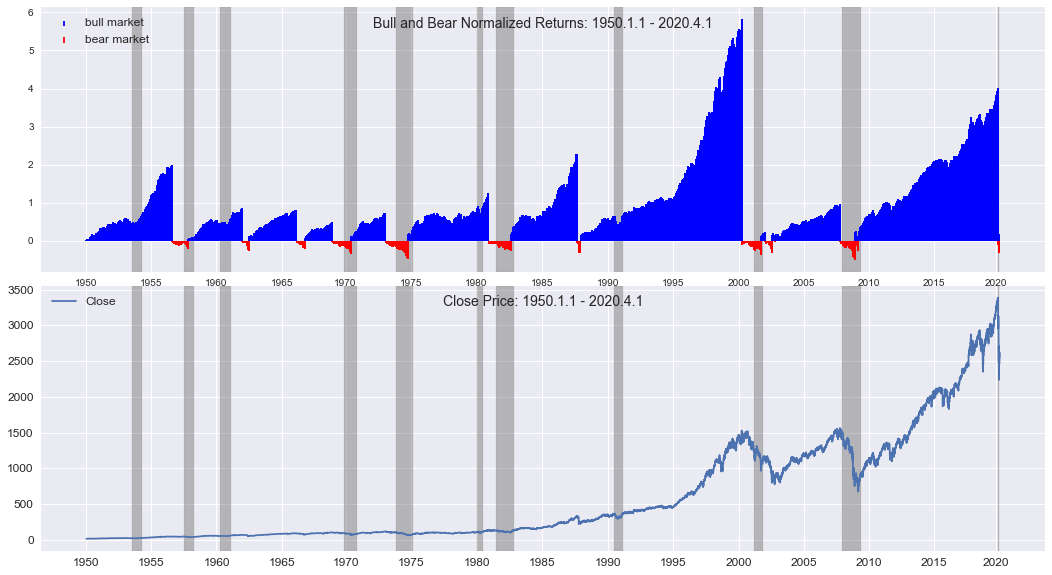

In [423]:

%run fmplot

enddate=test_e
startdate=dt.datetime(1950,1,1)
enddate=dt.datetime(2020,4,1)

#startdate=dt.datetime(2007,2,1)
#enddate=dt.datetime(2020,8,1)

#plotmc(dfmc,'mcnr',stemlw=2)
#plot_mktcycle(dfmc,'mcnr',startdate=startdate,enddate=enddate,stemlw=2,
#              fb=recessions)

title=['Bull and Bear Normalized Returns', 'Close Price']
variables=['mcnr','Close']
fmplot(dfmc,variables,titles=title,startdate=startdate,enddate=enddate,stemlw=2,fb=recessions,
          plottypes=['mktcycle','line'], 
          hspace=0.05,titlein=True, figsize=(18,10),titledate=True)

# print(dfmc.loc[startdate:enddate,['mkt','mcupm','muchp','mdcup']])
# useful signals here are 
#   mcnr and mkt (truth variable/label, cannot be used as feature, leakage!!!)
#   mucdown
#   mdcup
#   mcupm

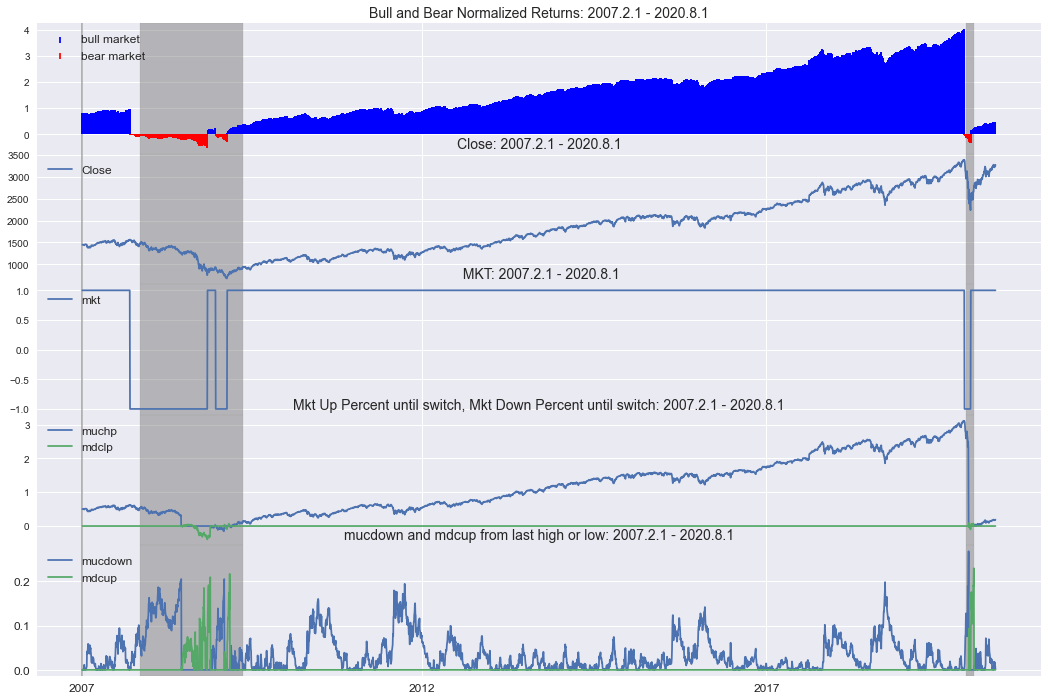

In [651]:
%run fmfunctions
%run fmplot

enddate=test_e
#startdate=dt.datetime(1950,1,1)
#enddate=dt.datetime(2020,4,1)

startdate=dt.datetime(2007,2,1)
enddate=dt.datetime(2020,8,1)

#plotmc(dfmc,'mcnr',stemlw=2)
#plot_mktcycle(dfmc,'mcnr',startdate=startdate,enddate=enddate,stemlw=2,
#              fb=recessions)

title=['Bull and Bear Normalized Returns', 'Close',' MKT',
       'Mkt Up Percent until switch, Mkt Down Percent until switch', 'mucdown and mdcup from last high or low']
variables=['mcnr','Close','mkt',['muchp','mdclp'],['mucdown','mdcup']]
fmplot(dfmc,variables,titles=title,startdate=startdate,enddate=enddate,stemlw=2,fb=recessions,
          plottypes=['mktcycle','line','line','line','line'], 
          hspace=0.00,titlein=False, figsize=(18,12),titledate=True)

# print(dfmc.loc[startdate:enddate,['mkt','mcupm','muchp','mdcup']])
# useful signals here are 
#   mcnr and mkt (truth variable/label, cannot be used as feature, leakage!!!)
#   mucdown
#   mdcup
#   mcupm

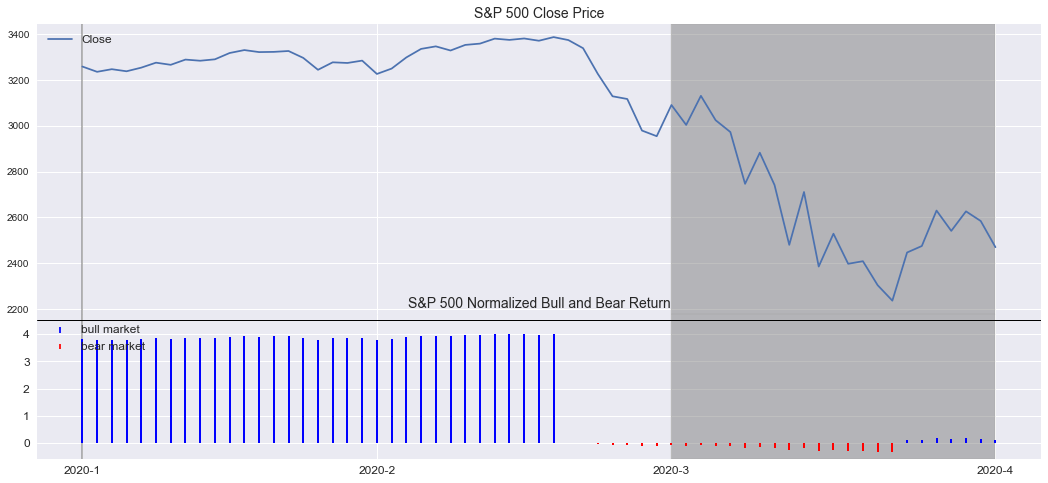

In [483]:
# Plot S&P and Market Cycle
figsize=(18,8)
startdate=dt.datetime(2020,1,1)
enddate=dt.datetime(2020,4,1)

#print('dfmc1 last index =',dfmc1.index[len(dfmc2.index)-1])
titles=['S&P 500 Close Price','S&P 500 Normalized Bull and Bear Return']
variables=['Close','mcnr']
fmplot(dfmc,variables,startdate=startdate,enddate=enddate,
               plottypes=['line','mktcycle'],figsize=figsize,fb=recessions,sharex=True, hspace=0,
               titles=titles,titlexy=[(0.5,0.9),(0.5,0.8)],height_ratios=[2,1],hlines =['',4.5])

plt.show()

In [168]:
dfmc.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'Adj Close', 'mkt', 'mchlm',
       'newmhlm', 'sdm', 'mcupm', 'mcnr', 'mucdown', 'mdcup', 'mcudthr',
       'muchp', 'mdclp', 'dfhlm'],
      dtype='object')

# Step 3. Join & Transform

In [265]:
market_variables=['Close','Low','High','Open','Volume','mcnr','mkt','mucdown','mdcup','mcupm']
dfmc1=dfmc[market_variables].copy()
#print('dfmc1 last index =',dfmc1.index[len(dfmc2.index)-1])
display(dfmc1.tail(3))

,Close,Low,High,Open,Volume,mcnr,mkt,mucdown,mdcup,mcupm
Date,,,,,,,,,,
2020-08-20,3385.510010,3354.689941,3390.800049,3360.479980,3.642850e+09,0.513145,1,0.00125967,0,1
2020-08-21,3397.159912,3379.310059,3399.959961,3386.010010,3.705420e+09,0.518352,1,0,0,1
2020-08-24,3431.280029,3413.129883,3432.090088,3418.090088,3.728690e+09,0.533602,1,0,0,1


In [278]:
dfmc1.dtypes

Close      float64
Low        float64
High       float64
Open       float64
Volume     float64
mcnr        object
mkt         object
mucdown     object
mdcup       object
mcupm       object
dtype: object

#### Join Yield Curve

join columns = ['T10Y3M', 'T10Y3M_ema10']


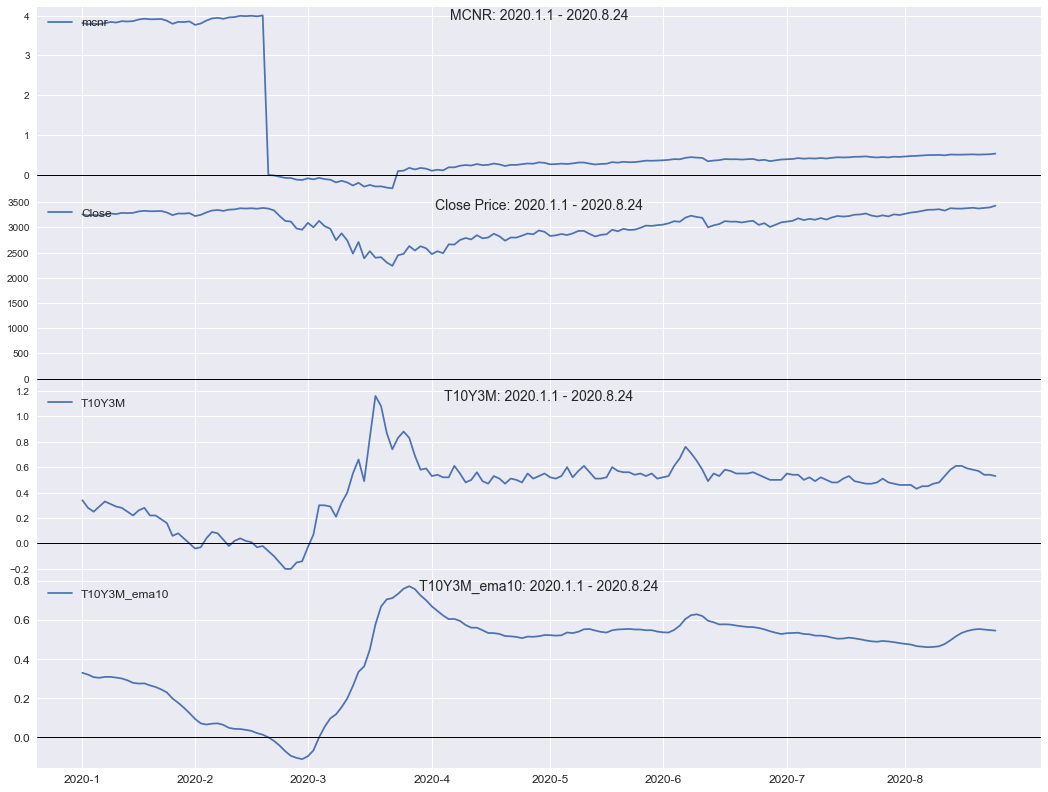

In [267]:
# Join and Plot Yield Curve

dfycurve=dfema(dft10y3m,'T10Y3M',windows=[10])
dfycurve.tail()

joincols=['T10Y3M','T10Y3M_ema10']
dfmc2=fmjoinff(dfmc1,dfycurve,joincols=joincols,market_variables=market_variables,verbose=False,dropnas=True)

startdate = dt.datetime(1982,1,1)
startdate = dt.datetime(2020,1,1)
enddate = dt.datetime(2020,8,24)

variables=['mcnr','Close','T10Y3M', 'T10Y3M_ema10']
titles=['MCNR'  ,'Close Price','T10Y3M', 'T10Y3M_ema10']
hlines=[0,0,0,0]
fmplot(dfmc2,variables,titles=titles, 
          startdate=startdate,enddate=enddate, figsize=(18,14),
          titledate=True, hlines=hlines,hspace=0,sharex=False, titlein=True)

#### Join GDP 
* GDP is reported quarterly  
* A recession is defined as two quarters of successive decrease in GDP
* QoQ and prevQoQ will provide recession input as predictive features



join columns = ['GDP', 'gdp_qoq', 'gdp_prevqoq', 'recession1q', 'recession2q']


,Close,Low,High,Open,Volume,mcnr,mkt,mucdown,mdcup,mcupm,T10Y3M,T10Y3M_ema10,GDP,gdp_qoq,gdp_prevqoq,recession1q,recession2q
2020-08-20,3385.510010,3354.689941,3390.800049,3360.479980,3.642850e+09,0.513145,1,0.00125967,0,1,0.54,0.551525,19408.759,-9.982682,-0.773087,1.0,1.0
2020-08-21,3397.159912,3379.310059,3399.959961,3386.010010,3.705420e+09,0.518352,1,0,0,1,0.54,0.549430,19408.759,-9.982682,-0.773087,1.0,1.0
2020-08-24,3431.280029,3413.129883,3432.090088,3418.090088,3.728690e+09,0.533602,1,0,0,1,0.53,0.545897,19408.759,-9.982682,-0.773087,1.0,1.0


<bound method NDFrame.head of                   GDP   gdp_qoq
1950-01-03    280.828  3.769395
1950-01-04    280.828  3.769395
1950-01-05    280.828  3.769395
1950-01-06    280.828  3.769395
1950-01-09    280.828  3.769395
...               ...       ...
2020-08-18  19408.759 -9.982682
2020-08-19  19408.759 -9.982682
2020-08-20  19408.759 -9.982682
2020-08-21  19408.759 -9.982682
2020-08-24  19408.759 -9.982682

[17712 rows x 2 columns]>

['Close' 'Low' 'High' 'Open' 'Volume' 'mcnr' 'mkt' 'mucdown' 'mdcup'
 'mcupm' 'T10Y3M' 'T10Y3M_ema10' 'GDP' 'gdp_qoq' 'gdp_prevqoq'
 'recession1q' 'recession2q']


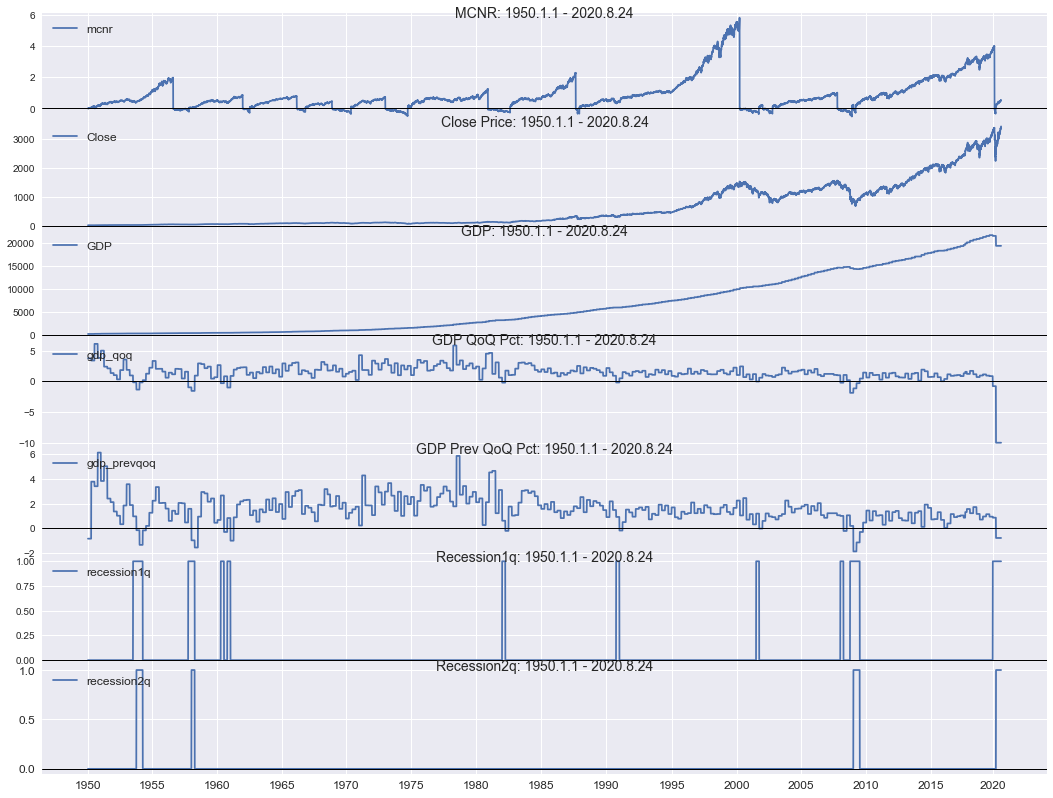

In [268]:
# Join GDP
%run fmfunctions
%run fmplot


# GDP Variable Transforrmations
df_gdp = gdpqoq(dfgdp,'GDP')

joincols=['GDP', 'gdp_qoq', 'gdp_prevqoq','recession1q' ,'recession2q']
dfmc3=fmjoinff(dfmc2,df_gdp,joincols=joincols,market_variables=market_variables,verbose=False,dropnas=True)

display(dfmc3.tail(3))

# Plot 

startdate = dt.datetime(1950,1,1)

#startdate = dt.datetime(2007,1,1)
#enddate = dt.datetime(2010,8,1)
#startdate = dt.datetime(2019,1,1)
#enddate = dt.datetime(2020,4,1)
#startdate = dt.datetime(1947,1,1)
#enddate = dt.datetime(2020,4,14)
#startdate = dt.datetime(2001,6,28)
#enddate = dt.datetime(2002,1,1)
#startdate = dt.datetime(2008,1,1)
#enddate = dt.datetime(2010,8,1)
#startdate= dfmc3.index[0]
enddate = dfmc3.index[len(dfmc3.index)-1]

variables=['mcnr','Close','GDP', 'gdp_qoq', 'gdp_prevqoq','recession1q' ,'recession2q']
titles=['MCNR'  ,'Close Price','GDP', 'GDP QoQ Pct', 'GDP Prev QoQ Pct', 'Recession1q','Recession2q']

display(dfmc3.loc[startdate:enddate,['GDP','gdp_qoq']].head)

print(dfmc3.columns.values)

hlines = [0,0,0,0,0,0,0]
fmplot(dfmc3,variables,titles=titles, 
          startdate=startdate,enddate=enddate, figsize=(18,14),
          titledate=True, hlines=hlines,hspace=0,sharex=False, titlein=True)

# Start date 2008.1.1 to 2010.1.1
#    - GDP is considered coincident indicator, though examples here show it to be lagging clearly lags ... GDP goes negative after the downturn, and goes positive after the upturn 
#    - Not sure this will be useful, given it is lagging
#    - Include the following two varialbles and study 
#    - gdp_qoq, gdp_prevqoq

### Leading Economic Indicators
Conference Board LEI Leading Economic Index

**Useful Econommic Indicators**
* **Unemployment**, https://fred.stlouisfed.org/series/UNRATE ... Good .. 
 * Unemployment data published by FRED. Updated monthly. Timely updates within a month. Additionaly, there are forecasts available which can be added to the data set so as to generate a useful feature until the actual data is published. During the Month of March, for example, several forecasts were reported in the news, indicating that jobless claims were rising. These can be input to the data set, until the real official data is available. 
  
* **Consumer Price Index (CPI)** alfredgraph.csv  the CPI measures inflation  
 *  https://alfred.stlouisfed.org/series?seid=CPIAUCSL  ... 1982-1984 = 100 ... 
 * observation march of 2020 $257.953 ... 
 * how to normalize the CPI data ... https://www.bls.gov/cpi/factsheets/cpi-math-calculations.pdf ... a copy of this pdf is in workspace/pyquant
 * Useful for market prediction and economic prediction. See reference for additional explanation    
 * https://investinganswers.com/dictionary/c/consumer-price-index-cpihttps://investinganswers.com/dictionary/c/consumer-price-index-cpi 


* **Put/Call Ratios** (Sentiment) this is difficult data to get ...
  * for the future ... the plan is to piece together a feature from several sources 2003 to current. The data can be used for predictions from 2003 onward.
 * Not available for the entire market history back to 1950's or even 1970's. 
 * Thus, will not use for S&P 500 cycle prediction.
 * However, do use this for prediction on specific equities
 * https://www.theocc.com/webapps/historical-volume-query ... occ historical volume query ... 
   * for years 2016 to current. this can be pieced together with cboe to create one predictor
 * http://www.cboe.com/data/historical-options-data/volume-put-call-ratios ... 
   * cboe historical and recent. Recent only goes up to 2019/10/04
   * cboe_pcratioarchive_2003_to_2012.csv 
   * cboe_indexpc_2006_to_20191004.csv
   
* **Conference Board** not available as open source, availabe for purchase only
  * https://en.wikipedia.org/wiki/Conference_Board_Leading_Economic_Index

* https://fred.stlouisfed.org/series/USSLIND ... XX 2 month+ lag in publishing montly data. For exmaple, 02-01-2020 data published in mid April. Makes this almost useless to include in a predictive dataset, because the data is just not available.



### Observations

* Economy often follows the Market, not before
* Economic recesions generally tend to follow the onset of a Bear Market, in other words, the market leads the economy.
* Unemployment - observing the chart, the unemployment rate follows the onset of a recesion
* CPI - on its own the CPI is not normalized so there it is difficult to decern incite over long periods of time
* CPI Monthly YoY - Interestingly, based on visual observation the chart below, the year over year monthly change in CPI does seem to show some leading indciation of recessions. This could possible be a good predictive feature.
* CPI Monthly YOY Velocity - could also be a good feature, to know if CPI monthly yoy has a positive or negative velocity, and a large or small value.


#### Join UNRATE and CPI

join columns = ['UNRATE']
join columns = ['CPIAUCSL', 'cpimom', 'cpimomvelocity']
['Close' 'Low' 'High' 'Open' 'Volume' 'mcnr' 'mkt' 'mucdown' 'mdcup'
 'mcupm' 'T10Y3M' 'T10Y3M_ema10' 'GDP' 'gdp_qoq' 'gdp_prevqoq'
 'recession1q' 'recession2q' 'UNRATE' 'CPIAUCSL' 'cpimom' 'cpimomvelocity']


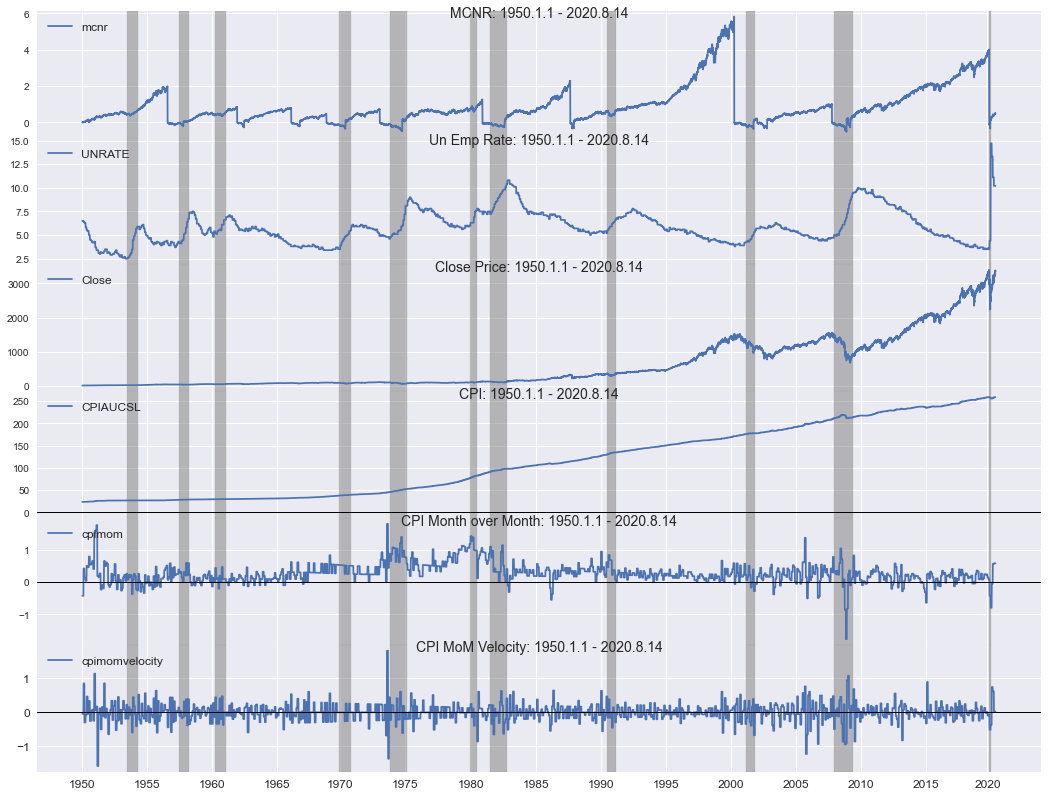

In [269]:
# LEI's   Unemployment and Consumer Price Index
%run fmfunctions
%run fmplot

# Unemployment Rate

joincols=['UNRATE']
dfmc4=fmjoinff(dfmc3,dfunrate,joincols=joincols,market_variables=market_variables,verbose=False,dropnas=True)

# CPI
v='CPIAUCSL'
df_cpi=cpimom(dfcpiaucsl,v)
joincols = [ 'CPIAUCSL', 'cpimom','cpimomvelocity' ]
dfmc4=fmjoinff(dfmc4,df_cpi,joincols=joincols,market_variables=market_variables,verbose=False,dropnas=True)

startdate = dt.datetime(1950,1,1)
#startdate = dt.datetime(1999,1,1)
#enddate = dt.datetime(2003,1,1)
#startdate = dt.datetime(2007,1,1)
#enddate = dt.datetime(2010,8,1)
#startdate = dt.datetime(2019,1,1)
#enddate = dt.datetime(2020,4,1)
#startdate = dt.datetime(1947,1,1)
enddate = dt.datetime(2020,8,14)

print(dfmc4.columns.values)
    
titles=['MCNR','Un Emp Rate', 'Close Price', 'CPI','CPI Month over Month','CPI MoM Velocity']
variables=[ 'mcnr', 'UNRATE','Close'  ,'CPIAUCSL', 'cpimom','cpimomvelocity' ]   
hlines=['','','',0,0,0]
fmplot(dfmc4,variables,titles=titles, startdate=startdate,enddate=enddate,
          fb=recessions,figsize=(18,14), hspace=0,titleappenddate=True,hlines=hlines,
          titledate=True, titlein=True, sharex=True)

# variables to include for ML
#   UNRATE, CPIAUCSL_20200410, cpimom
# Look at startdate 2008.1.1 to 2010.1.1
#  see the UNRATE (unemployment rate) rising, while the closing price is falling
#  see the CPI (consumer price index) rising , while the closing_price is falling
#    the CPI seems to be a strong leading indicator that UNRATE, which seems to lag
#  CPI MOM seems to take a negative turn just as the market is about to turn positive from negative

# Look at startdate 2019.1.1 to 2020.4.1
#  UNRATE takes a sharp spike up as the market turns
#  Again here we see CPI MOM seems to take a negative, ust before the recovery





Join Consumer Sentiment
https://fred.stlouisfed.org/series/UMCSENT?utm_source=series_page&utm_medium=related_content&utm_term=related_resources&utm_campaign=categories 




### University of Michigan Consumer Sentiment/Confidence

* Historical Univ Mich data published St. Louis Fed
* https://fred.stlouisfed.org/series/UMCSENT 
   * Data from 11/1/1952 to 3/1/2020 updated monthly
   
* The data is relased monthly by Univ of Michigan
  * FRED lags publishing the data (sometimes by a couple of months
  * ... so go to Univ of Michigan sight and add the latest data
  * http://www.sca.isr.umich.edu/ 

* Consumer Confidence/Sentiment ... in many instances consumer confidence is high and then crashes after the market crashes, so is not always useful for market prediction.

#### Important note about Consumer Sentiment and data fields
... it is important that the data comming in is clean.

For example, the UMCSENT.csv file was manually edited to add 19 or 20 to the year. Fields with null or empty values were also dropped. Reading in row without values will case the averages and other functions to generate flakey results.


#### Join Consumer Sentiment

join columns = ['UMCSENT', 'csentmom', 'csentmom_sma3', 'csentmom_std3']
['Close' 'Low' 'High' 'Open' 'Volume' 'mcnr' 'mkt' 'mucdown' 'mdcup'
 'mcupm' 'T10Y3M' 'T10Y3M_ema10' 'GDP' 'gdp_qoq' 'gdp_prevqoq'
 'recession1q' 'recession2q' 'UNRATE' 'CPIAUCSL' 'cpimom' 'cpimomvelocity'
 'UMCSENT' 'csentmom' 'csentmom_sma3' 'csentmom_std3']


,Close,Low,High,Open,Volume,mcnr,mkt,mucdown,mdcup,mcupm,...,recession1q,recession2q,UNRATE,CPIAUCSL,cpimom,cpimomvelocity,UMCSENT,csentmom,csentmom_sma3,csentmom_std3
2020-08-20,3385.510010,3354.689941,3390.800049,3360.479980,3.642850e+09,0.513145,1,0.00125967,0,1,...,1.0,1.0,10.2,258.723,0.586671,0.021315,89.1,-11.9,-3.4,7.369532
2020-08-21,3397.159912,3379.310059,3399.959961,3386.010010,3.705420e+09,0.518352,1,0,0,1,...,1.0,1.0,10.2,258.723,0.586671,0.021315,89.1,-11.9,-3.4,7.369532
2020-08-24,3431.280029,3413.129883,3432.090088,3418.090088,3.728690e+09,0.533602,1,0,0,1,...,1.0,1.0,10.2,258.723,0.586671,0.021315,89.1,-11.9,-3.4,7.369532


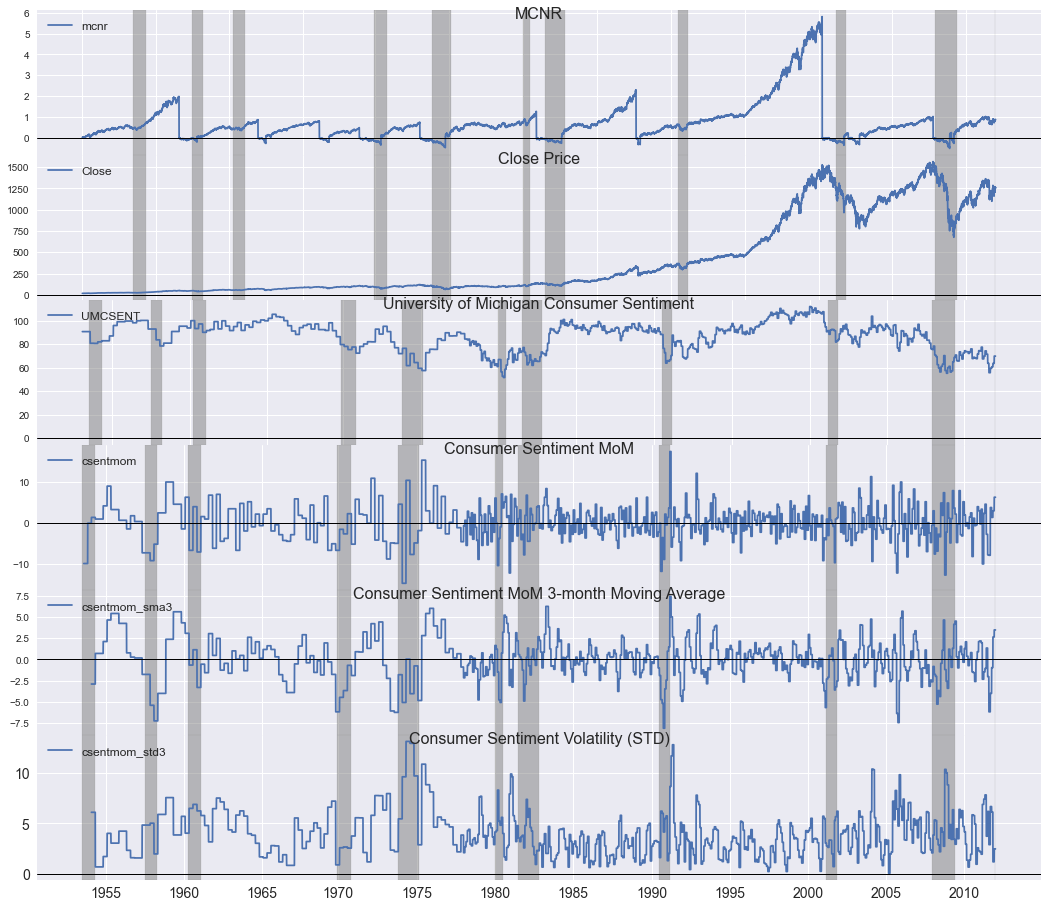

In [306]:
# University of Michigan Sentiment
%run fmfunctions
%run fmplot

window=3
v='UMCSENT'
df_umcsent = csentmom(dfumcsent,v,window=window)

joincols=['UMCSENT','csentmom','csentmom_sma3','csentmom_std3']
dfmc5=fmjoinff(dfmc4,df_umcsent,joincols=joincols,market_variables=market_variables,verbose=False,dropnas=True)

startdate = dt.datetime(1950,1,1)
#enddate = dt.datetime(2000,8,1)
#startdate = dt.datetime(1999,1,1)
#enddate = dt.datetime(2005,1,1)
#startdate = dt.datetime(2006,1,1)
#enddate = dt.datetime(2010,1,1)
#startdate = dt.datetime(2019,1,1)
#enddate = dt.datetime(2020,4,1)
#startdate = df_umcsent.index[0]
#enddate = df_umcsent.index[len(df_umcsent.index)-1] 

print(dfmc5.columns.values)

display(dfmc5.tail(3))

variables=['mcnr','Close','UMCSENT','csentmom','csentmom_sma3','csentmom_std3']
fmplot(dfmc5,variables,titles=['MCNR','Close Price'  ,'University of Michigan Consumer Sentiment','Consumer Sentiment MoM', 
                                  'Consumer Sentiment MoM 3-month Moving Average','Consumer Sentiment Volatility (STD)'], 
          startdate=startdate,enddate=enddate,fb=recessions,fylims=['',(0,120),'','',''],hlines=[0,0,0,0,0,0],figsize=(18,16),
          titleappenddate=True,titlein=True,title_fontsize=16,xtick_labelsize=14,
          ytick_labelsize=14,pltstyle='seaborn', hspace=0)

# looking at the 1999, 2008, and 2020 crashes its hard to day if consumer sentiment will help
#  put in the UMCSENT and csentmom into the ML variables and look at correlations to the market


# startdate 2008.1.1 to 2010.1.1
#    cpimom goes negative after the downturn
# startdate 1999.1.1 to 2003.1.1
#    cpimom goes negative toward tail end of recesion and then positive at tail end of recesion
#    
# not clear that that this variable will help
#  csentmom, UMCSENT ... include in ML dataframe and look at correlations 
#  csentmom volatile and does not show visually clear correlation 
#  csentmom is positive and negative during up and down markets


In [271]:
df_umcsent.columns

Index(['UMCSENT', 'lastmonth', 'csentmom', 'csentmom_sma3', 'csentmom_std3'], dtype='object')

### Momentum Variables: ADX and Moving Averages

#### Momentum Simple Moving Averages

Momentum is often measured in terms of moving averages. Investopedia provides a convenient overview. https://www.investopedia.com/ask/answers/122414/what-are-most-common-periods-used-creating-moving-average-ma-lines.asp 

Moving averages are one of the most commonly used technical indicators in stock, futures and forex trading. The 50-day and 200 day moving averages lend significant insights. For example, here is what Investopedia has to say. 

* Traders and market analysts commonly use several periods in creating moving averages to plot on their charts. For identifying significant, long-term support and resistance levels and overall trends, the 50-day, 100-day, and 200-day moving averages are the most common. 
* Based on historical statistics, these longer-term moving averages are considered more reliable trend indicators and less susceptible to temporary fluctuations in price. The 200-day moving average is considered especially significant in stock trading. As long as the 50-day moving average of a stock price remains above the 200-day moving average, the stock is generally thought to be in a bullish trend. A crossover to the downside of the 200-day moving average is interpreted as bearish.

Thus, from the perspective of Investopedia, 

* The relative position of the 200-day and 50-day moving averages have significant insight. 
* When we compare the 200-day and 50-day forecasts we observe the 50-day forecast moving below the 200-day forecast in the 2020 lockdown recesion
* We observe the same period with the ADX system, the ADX system is much more responsive and identifies both the "bullish" and "bearish" trends.
* In comparison, the relative 50-day to 200-day trend lags the ADX system in indentfying the "bearish" trend and does not yet identify the "bullish" trend, over the same period.


### ADX momentum
ADX
https://www.google.com/search?q=python+calculating+adx&rlz=1C5CHFA_enUS819US819&oq=python+calculating+adx+&aqs=chrome..69i57j0j69i64.5444j0j1&sourceid=chrome&ie=UTF-8#kpvalbx=_7kieXpTbINLQ-gSFkJOwAQ34

['Close' 'Low' 'High' 'Open' 'Volume' 'mcnr' 'mkt' 'mucdown' 'mdcup'
 'mcupm' 'T10Y3M' 'T10Y3M_ema10' 'GDP' 'gdp_qoq' 'gdp_prevqoq'
 'recession1q' 'recession2q' 'UNRATE' 'CPIAUCSL' 'cpimom' 'cpimomvelocity'
 'UMCSENT' 'csentmom' 'csentmom_sma3' 'csentmom_std3' 'Close_sma5'
 'Close_sma10' 'Close_sma20' 'Close_sma50' 'Close_sma100' 'Close_sma200'
 'Volume_sma5' 'Volume_sma10' 'Volume_sma20' 'Volume_sma50'
 'Volume_sma100' 'Volume_sma200' 'Close_nma1' 'Volume_nma1' 'Close_nma5'
 'Volume_nma5' 'Close_nma10' 'Volume_nma10' 'Close_nma15' 'Volume_nma15'
 'Close_nma20' 'Volume_nma20' 'Close_nma30' 'Volume_nma30' 'Close_nma50'
 'Volume_nma50' 'Close_nma200' 'Volume_nma200' 'rma_sma50_sma200'
 'rma_vma50_vma200' 'yesterday_closePrice' 'yesterday_HighPrice'
 'yesterday_lowPrice' 'truerange' 'ATR50' 'moveUp' 'moveDown' 'PDM50'
 'NDM50' 'emaPDM50' 'emaNDM50' 'PDI50' 'NDI50' 'absPDImNDI'
 'ema_abs_PDImNDI' 'ADX' 'logret' 'Close_lrstd50' 'Close_lrstd76'
 'Close_lrstd126' 'Close_lrstd252']


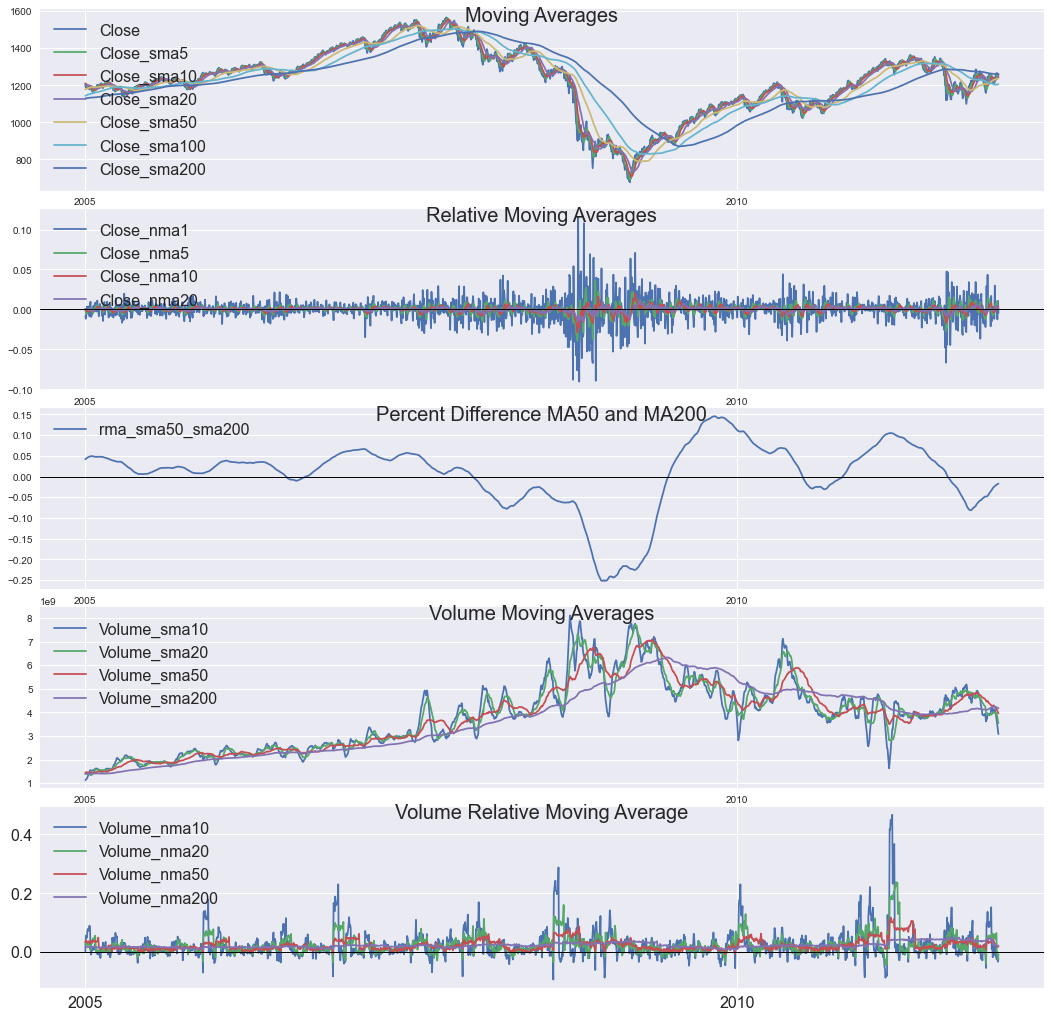

In [305]:
# Momentum, moving averages from investopedia
%run fmfunctions
%run fmplot

# close price simple moving averages
v='Close'
dfmc6=dfsma(dfmc5,v,windows=[5,10,20,50,100,200])

# simple moving average
v='Volume'
dfmc6=dfsma(dfmc5,v,windows=[5,10,20,50,100,200])

# normalized mavgs
#   1-day (today / yesterday .... sma5 = 5-day smavg( today / yesterday ) .... )
v=['Close','Volume']
dfmc6=dfnma(dfmc6,v,windows=[1,5,10,15,20,30,50,200])

# relative 200-day moving average
# scale of 0 to 1
dfmc6=dfrma(dfmc6,'Close_sma50','Close_sma200',varname='rma_sma50_sma200')

# relative volume 50 day ma divided by 200 day ma
dfmc6=dfrma(dfmc6,'Volume_sma50','Volume_sma200',varname='rma_vma50_vma200')


startdate = dt.datetime(1976,6,1)
enddate = dt.datetime(2000,8,1)
startdate = dt.datetime(2005,1,1)
enddate = dt.datetime(2012,1,1)
#startdate = dt.datetime(2020,3,1)
#enddate = dt.datetime(2020,4,14)

print(dfmc6.columns.values)

titles=['Moving Averages','Relative Moving Averages','Percent Difference MA50 and MA200',
        'Volume Moving Averages', 'Volume Relative Moving Average']
variables=[['Close','Close_sma5','Close_sma10','Close_sma20','Close_sma50', 
            'Close_sma100','Close_sma200'], 
           ['Close_nma1', 'Close_nma5', 'Close_nma10', 'Close_nma20'],
           ['rma_sma50_sma200'],['Volume_sma10','Volume_sma20','Volume_sma50','Volume_sma200'],
           ['Volume_nma10','Volume_nma20','Volume_nma50','Volume_nma200']]

fmplot(dfmc6,variables,titles=titles,startdate=startdate, figsize=[18,18],
          enddate=enddate, llocs=['center left','upper left','upper left','upper left','upper left'],hlines=['',0,0,'',0], 
          title_fontsize=20, titlein=True,
          xtick_labelsize=16, ytick_labelsize=16,legend_fontsize=16)


# ML needs normalized features. Consider the following
# These relative ma track the relative price and seem to be good signals 
  #  **close_price_nma1, close_price_nma5, 50, 200  ... zoom in to start - end: 2020-3-1 to 2020-4-14 
  #  ** rma_sma50_sma200 percent diff close_price_sma50 and close_price_sma 200 
  #     indicates bullish or bearish trend
# Volume
  # 50 day moving average volume is correlated with 2008 financial crisis downturn
  # **use the 50-day volume relative moving average. Seems like good responsiveness 

#### ADX - Average Directional Index

['Close' 'Low' 'High' 'Open' 'Volume' 'mcnr' 'mkt' 'mucdown' 'mdcup'
 'mcupm' 'T10Y3M' 'T10Y3M_ema10' 'GDP' 'gdp_qoq' 'gdp_prevqoq'
 'recession1q' 'recession2q' 'UNRATE' 'CPIAUCSL' 'cpimom' 'cpimomvelocity'
 'UMCSENT' 'csentmom' 'csentmom_sma3' 'csentmom_std3' 'Close_sma5'
 'Close_sma10' 'Close_sma20' 'Close_sma50' 'Close_sma100' 'Close_sma200'
 'Volume_sma5' 'Volume_sma10' 'Volume_sma20' 'Volume_sma50'
 'Volume_sma100' 'Volume_sma200' 'Close_nma1' 'Volume_nma1' 'Close_nma5'
 'Volume_nma5' 'Close_nma10' 'Volume_nma10' 'Close_nma15' 'Volume_nma15'
 'Close_nma20' 'Volume_nma20' 'Close_nma30' 'Volume_nma30' 'Close_nma50'
 'Volume_nma50' 'Close_nma200' 'Volume_nma200' 'rma_sma50_sma200'
 'rma_vma50_vma200' 'yesterday_closePrice' 'yesterday_HighPrice'
 'yesterday_lowPrice' 'truerange' 'ATR50' 'moveUp' 'moveDown' 'PDM50'
 'NDM50' 'emaPDM50' 'emaNDM50' 'PDI50' 'NDI50' 'absPDImNDI'
 'ema_abs_PDImNDI' 'ADX']


,Close,PDI50,NDI50,ADX
1950-01-03,16.66,NaN,NaN,NaN
1950-01-04,16.85,3.921569,0.0,100.000000
1950-01-05,16.93,5.544858,0.0,71.872483


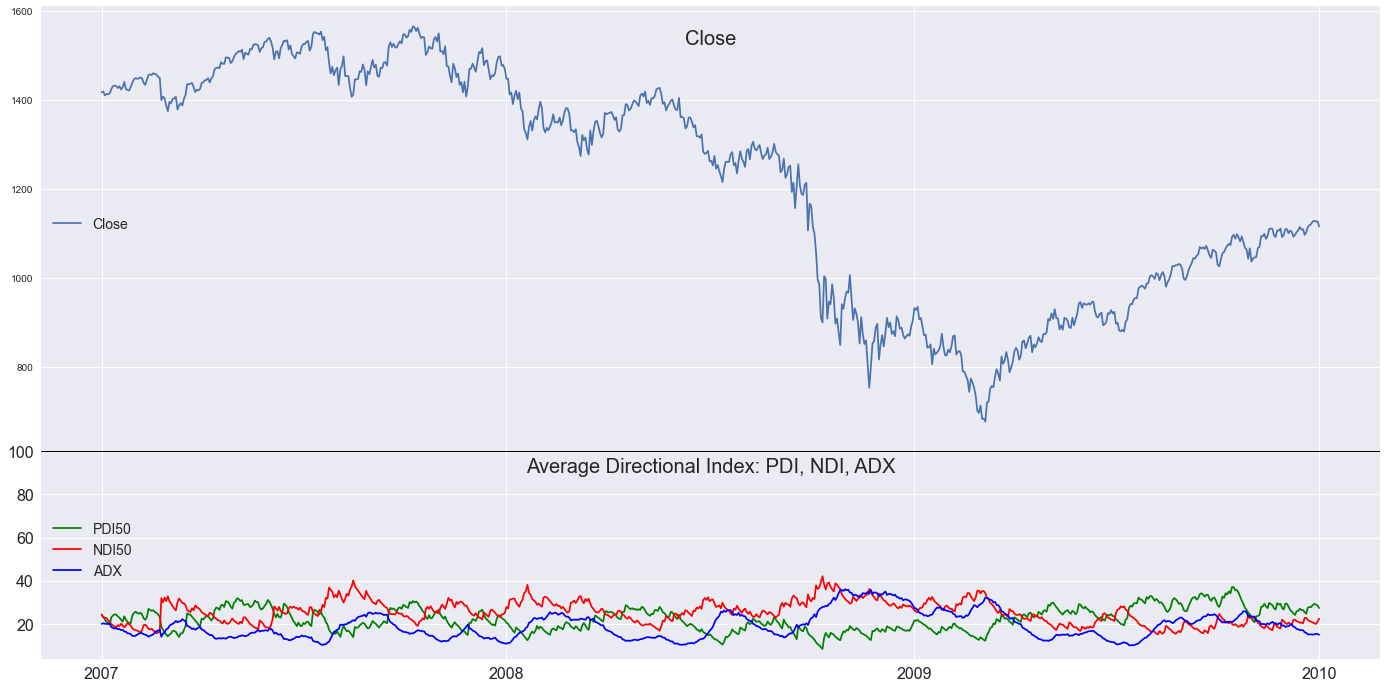

In [273]:
# Momentum with Average Directional Index (ADX)

%run fmfunctions
%run fmplot

# create dataframes
# a window of 50 signifiantly smooths out the ADX curves 
#  and witn window=50 visually look to give a strong negative signal 
#  on the steep and deep part of the market crash
#  additionally, it seem responsive for the market coming back
dfmc7=dfadx(dfmc6,'Close','High','Low',window=50)
print(dfmc7.columns.values)
display(dfmc7[['Close','PDI50','NDI50','ADX']].head(3))

# Visualize

startdate = dt.datetime(1976,6,1)
enddate = dt.datetime(2000,8,1)
startdate = dt.datetime(2007,1,1)
enddate = dt.datetime(2010,1,1)
#startdate = dt.datetime(2020,1,1)
#enddate = dt.datetime(2020,4,14)

titles=['Close', 'Average Directional Index: PDI, NDI, ADX']
fmplot(dfmc7,['Close',['PDI50','NDI50','ADX']],titles=titles,startdate=startdate, 
          enddate=enddate,hspace=0,titlein = True, titlexy=[(0.5,0.9),(0.5,0.83)],
          height_ratios=[2,1],hlines =['',100], llocs=['center left','center left'],
          linecolors=['',['g','r','b']], xtick_labelsize=16, ytick_labelsize=16, 
          legend_fontsize=14, sharex=True,title_fontsize=20)

### Volatility

#### Python Volatility Calculation
https://blog.quantinsti.com/volatility-and-measures-of-risk-adjusted-return-based-on-volatility/
 
Volatility Measures  ... see this for yahoo finance download


https://blog.quantinsti.com/volatility-and-measures-of-risk-adjusted-return-based-on-volatility/

historical volatility can be measured in increments ranging anywhere from 10 to 180 trading days.

Good example of Yahoo finance api 
```
import yfinance as yf

#Pull NIFTY data from Yahoo finance 
NIFTY = yf.download('^NSEI',start='2012-6-1', end='2016-6-1')
```

['Close' 'Low' 'High' 'Open' 'Volume' 'mcnr' 'mkt' 'mucdown' 'mdcup'
 'mcupm' 'T10Y3M' 'T10Y3M_ema10' 'GDP' 'gdp_qoq' 'gdp_prevqoq'
 'recession1q' 'recession2q' 'UNRATE' 'CPIAUCSL' 'cpimom' 'cpimomvelocity'
 'UMCSENT' 'csentmom' 'csentmom_sma3' 'csentmom_std3' 'Close_sma5'
 'Close_sma10' 'Close_sma20' 'Close_sma50' 'Close_sma100' 'Close_sma200'
 'Volume_sma5' 'Volume_sma10' 'Volume_sma20' 'Volume_sma50'
 'Volume_sma100' 'Volume_sma200' 'Close_nma1' 'Volume_nma1' 'Close_nma5'
 'Volume_nma5' 'Close_nma10' 'Volume_nma10' 'Close_nma15' 'Volume_nma15'
 'Close_nma20' 'Volume_nma20' 'Close_nma30' 'Volume_nma30' 'Close_nma50'
 'Volume_nma50' 'Close_nma200' 'Volume_nma200' 'rma_sma50_sma200'
 'rma_vma50_vma200' 'yesterday_closePrice' 'yesterday_HighPrice'
 'yesterday_lowPrice' 'truerange' 'ATR50' 'moveUp' 'moveDown' 'PDM50'
 'NDM50' 'emaPDM50' 'emaNDM50' 'PDI50' 'NDI50' 'absPDImNDI'
 'ema_abs_PDImNDI' 'ADX' 'logret' 'Close_lrstd50' 'Close_lrstd76'
 'Close_lrstd126' 'Close_lrstd252']


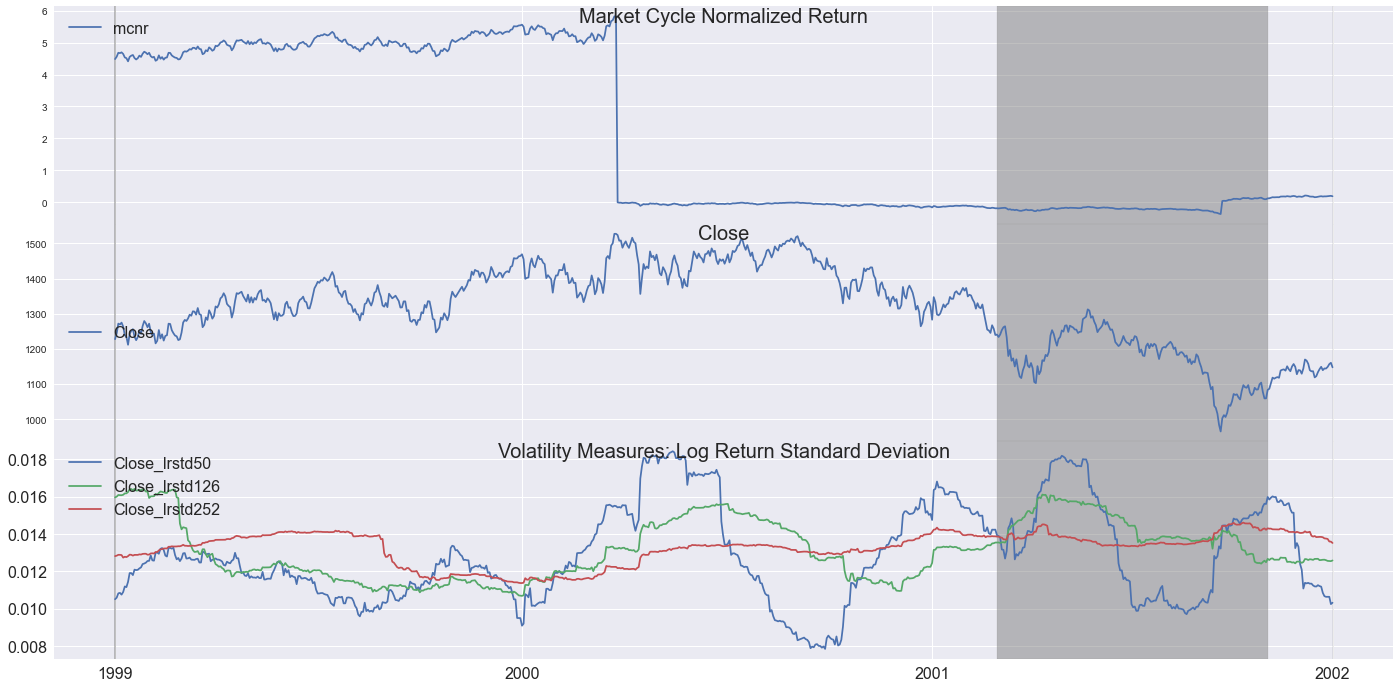

In [304]:
#def do_on_col(x, argument1):
%run fmfunctions
%run fmplot

v='Close'
dfmc8=dflogretstd(dfmc7,v,windows=[50,76,126,252])
startdate = dt.datetime(1950,1,1)
startdate = dt.datetime(1999,1,1)
enddate = dt.datetime(2002,1,1)
#enddate = dt.datetime(2020,4,1)
#startdate = dt.datetime(2004,1,1)
#enddate = dt.datetime(2010,8,1)
#startdate = dt.datetime(2019,1,1)
#enddate = dt.datetime(2020,4,14)

print(dfmc8.columns.values)

fmplot(dfmc8,['mcnr','Close',['Close_lrstd50','Close_lrstd126','Close_lrstd252']],
          titles=['Market Cycle Normalized Return', 'Close','Volatility Measures: Log Return Standard Deviation'],startdate=startdate, 
          enddate=enddate, llocs=['upper left', 'center left','upper left'],titlein=True, title_fontsize=20, hspace=0,fb=recessions,
          xtick_labelsize=16, ytick_labelsize=16,legend_fontsize=16)


# Start date 2008.1.1 to 2010.8.1
   # close_price_lrstd50 ... seems to react too quickly to localized volatility
   # close_price_lrstd126 ... seems to be a better doesn't react too quickly to localized trend
# Start date 2019.1.1 to 2020.4.1

# Step 4. ML Dataframe

In [275]:
print(dfmc8.columns.values)
dfmc8.tail(5)

['Close' 'Low' 'High' 'Open' 'Volume' 'mcnr' 'mkt' 'mucdown' 'mdcup'
 'mcupm' 'T10Y3M' 'T10Y3M_ema10' 'GDP' 'gdp_qoq' 'gdp_prevqoq'
 'recession1q' 'recession2q' 'UNRATE' 'CPIAUCSL' 'cpimom' 'cpimomvelocity'
 'UMCSENT' 'csentmom' 'csentmom_sma3' 'csentmom_std3' 'Close_sma5'
 'Close_sma10' 'Close_sma20' 'Close_sma50' 'Close_sma100' 'Close_sma200'
 'Volume_sma5' 'Volume_sma10' 'Volume_sma20' 'Volume_sma50'
 'Volume_sma100' 'Volume_sma200' 'Close_nma1' 'Volume_nma1' 'Close_nma5'
 'Volume_nma5' 'Close_nma10' 'Volume_nma10' 'Close_nma15' 'Volume_nma15'
 'Close_nma20' 'Volume_nma20' 'Close_nma30' 'Volume_nma30' 'Close_nma50'
 'Volume_nma50' 'Close_nma200' 'Volume_nma200' 'rma_sma50_sma200'
 'rma_vma50_vma200' 'yesterday_closePrice' 'yesterday_HighPrice'
 'yesterday_lowPrice' 'truerange' 'ATR50' 'moveUp' 'moveDown' 'PDM50'
 'NDM50' 'emaPDM50' 'emaNDM50' 'PDI50' 'NDI50' 'absPDImNDI'
 'ema_abs_PDImNDI' 'ADX' 'logret' 'Close_lrstd50' 'Close_lrstd76'
 'Close_lrstd126' 'Close_lrstd252']


,Close,Low,High,Open,Volume,mcnr,mkt,mucdown,mdcup,mcupm,...,PDI50,NDI50,absPDImNDI,ema_abs_PDImNDI,ADX,logret,Close_lrstd50,Close_lrstd76,Close_lrstd126,Close_lrstd252
2020-08-18,3389.780029,3370.149902,3395.060059,3387.040039,3.881310e+09,0.515053,1,0,0,1,...,28.640580,16.508004,12.132576,7.803101,17.283158,0.002301,0.013025,0.013268,0.029201,0.021150
2020-08-19,3374.850098,3369.659912,3399.540039,3392.510010,3.884480e+09,0.50838,1,0.0044044,0,1,...,28.277471,16.068785,12.208686,7.975869,17.985440,-0.004414,0.012987,0.012811,0.029202,0.021146
2020-08-20,3385.510010,3354.689941,3390.800049,3360.479980,3.642850e+09,0.513145,1,0.00125967,0,1,...,27.361774,16.890903,10.470871,8.073712,18.244574,0.003154,0.012957,0.012810,0.029188,0.021141
2020-08-21,3397.159912,3379.310059,3399.959961,3386.010010,3.705420e+09,0.518352,1,0,0,1,...,27.683169,16.571502,11.111668,8.192848,18.512956,0.003435,0.009382,0.012787,0.029027,0.021141
2020-08-24,3431.280029,3413.129883,3432.090088,3418.090088,3.728690e+09,0.533602,1,0,0,1,...,29.754899,16.037578,13.717321,8.409494,18.364357,0.009994,0.009323,0.012772,0.028904,0.021081


<table>
    <caption><center><strong>Table 1. Machine Learning Variables</strong></center></caption>
    <tr>
     <td width="30%" style="text-align:center;vertical-align:center;" ><strong>Description</strong></td>
     <td width="40%" style="text-align:center;vertical-align:center;" ><strong>Variables</strong></td>
     <td width="30%" style="text-align:center;vertical-align:center;" ><strong>Sources</strong></td>
    </tr>
     <tr>
        <td style="text-align:left;vertical-align:top;" >
            Normalized Market Variables <br>
            close_price, and volume
        </td>
        <td style="text-align:left;vertical-align:top;" >
          • close_price_nma1 -  1 day, relative ("normalized") price
            change <br>
          • volume_nma1 - 1-day relative ("normalized") <br>
            volume change <br>
           </td>
        <td style="text-align:left;vertical-align:top;" >
           • Yahoo S&P 500 data <br>
           • dfmc6
        </td>
      </tr>
      <tr>
         <td style="text-align:left;vertical-align:top;" >
            Market Cycle Variables <br>
         </td>  
         <td style="text-align:left;vertical-align:top;" >
            • mkt  = 1 up market (bull), -1 (bear) TARGET <br>
            • mdcup = market down cycle up percentage from previous low<br>
            • mucdown = market up cycle down percentage form prvious high<br>
            • mcupm = 1 when market up detected (when market crosses mcycleup),0 when market down detected (market crosses below mcycledown)
         </td>  
          <td style="text-align:left;vertical-align:top;" >
           • market_cycle function, derived from S&P 500 close_price <br>
           • dfmc1
         </td> 
      </tr>
       <tr>
       <td style="text-align:left;vertical-align:top;" >
           Normalized Simple Moving Averages <br>
           close_price, volume, normalized := today ÷ yesterday
        </td>
       <td style="text-align:left;vertical-align:top;" > 
            • close_price_nma50, close_price_nma200, volume_nma50, 
           rma_sma50_sma200   
       </td>
       <td style="text-align:left;vertical-align:top;" >
           • Yahoo S&P 500 data <br>
           • dfmc6
       </td>
       </tr>
       <tr>
           <td style="text-align:left;vertical-align:top;" >
            Average Directional Index, 50-day, ADX </td>
       <td style="text-align:left;vertical-align:top;" > 
            • ADI50, PDI50, ADX <br>  
       </td>
       <td style="text-align:left;vertical-align:top;" >
           • Yahoo S&P 500 data <br>
           • dfmc7
       </td>
       </tr>
         <tr>
           <td style="text-align:left;vertical-align:top;" >
           Leedng Economic Indicators (LEIs) </td>
       <td style="text-align:left;vertical-align:top;" > 
           • UNRATE - unemployment rate <br> 
           • CPIAUCSL_20200410 - CPI relative <br>
           • cpimom - month over month CPI
       </td>
       <td style="text-align:left;vertical-align:top;" >
           • FRED - St. Louis Federal Reserve Bank <br>
           • dfmc4
       </td>
       </tr>
       <tr>
           <td style="text-align:left;vertical-align:top;" >
           Yield Curve, 10Y Treasury to 3 Month, 10-Day EMA </td>
       <td style="text-align:left;vertical-align:top;" > 
           • T10Y3M - 10 Year to 3 Month Treasury yield, 10-day, EMA
       </td>
       <td style="text-align:left;vertical-align:top;" >
           • FRED - St. Louis Federal Reserve Bank <br>
           • dfmc2
       </td>
       </tr>
       <tr>
        <td style="text-align:left;vertical-align:top;" >
           Coincident and Lagging Indicators<br>
           GDP Coincident Indicator (though some consider it lagging) <br>
           CPI - Lagging Indicator
        </td>
         <td style="text-align:left;vertical-align:top;" > 
           • gdp_qoq, gdp_prevqoq<br>
           • UMCSENT, csentmom
         </td>
       <td style="text-align:left;vertical-align:top;" >
           • GDP, FRED - St. Louis Federal Reserve Bank, dfmc3 <br>
           • UMCSENT - St. Louis Federal Reserve Bank, dfmc5 
       </td>
       </tr>
       <tr>
           <td style="text-align:left;vertical-align:top;" >
           Volatility <br> 
           log return standard deviation</td>
       <td style="text-align:left;vertical-align:top;" > 
           • Close_price_lrstd50 <br>
           • Close_price_lrstd126
       </td>
       <td style="text-align:left;vertical-align:top;" >
           • S&P 500 <br>
           • dfmc8
       </td>
       </tr>

</table>

# Step 5. Correlate and Heatmap

['Close_nma1' 'Volume_nma1' 'mkt' 'mucdown' 'mdcup' 'mcupm' 'T10Y3M'
 'Close_nma50' 'Close_nma200' 'rma_sma50_sma200' 'Close_nma5'
 'Close_nma10' 'Close_nma15' 'Close_nma20' 'Close_nma30' 'UNRATE'
 'CPIAUCSL' 'cpimom' 'NDI50' 'PDI50' 'ADX' 'gdp_qoq' 'gdp_prevqoq'
 'UMCSENT' 'csentmom' 'Close_lrstd50' 'Close_lrstd126' 'mkt_50']
Close_nma1          float64
Volume_nma1         float64
mkt                 float64
mucdown             float64
mdcup               float64
mcupm               float64
T10Y3M              float64
Close_nma50         float64
Close_nma200        float64
rma_sma50_sma200    float64
Close_nma5          float64
Close_nma10         float64
Close_nma15         float64
Close_nma20         float64
Close_nma30         float64
UNRATE              float64
CPIAUCSL            float64
cpimom              float64
NDI50               float64
PDI50               float64
ADX                 float64
gdp_qoq             float64
gdp_prevqoq         float64
UMCSENT             float64

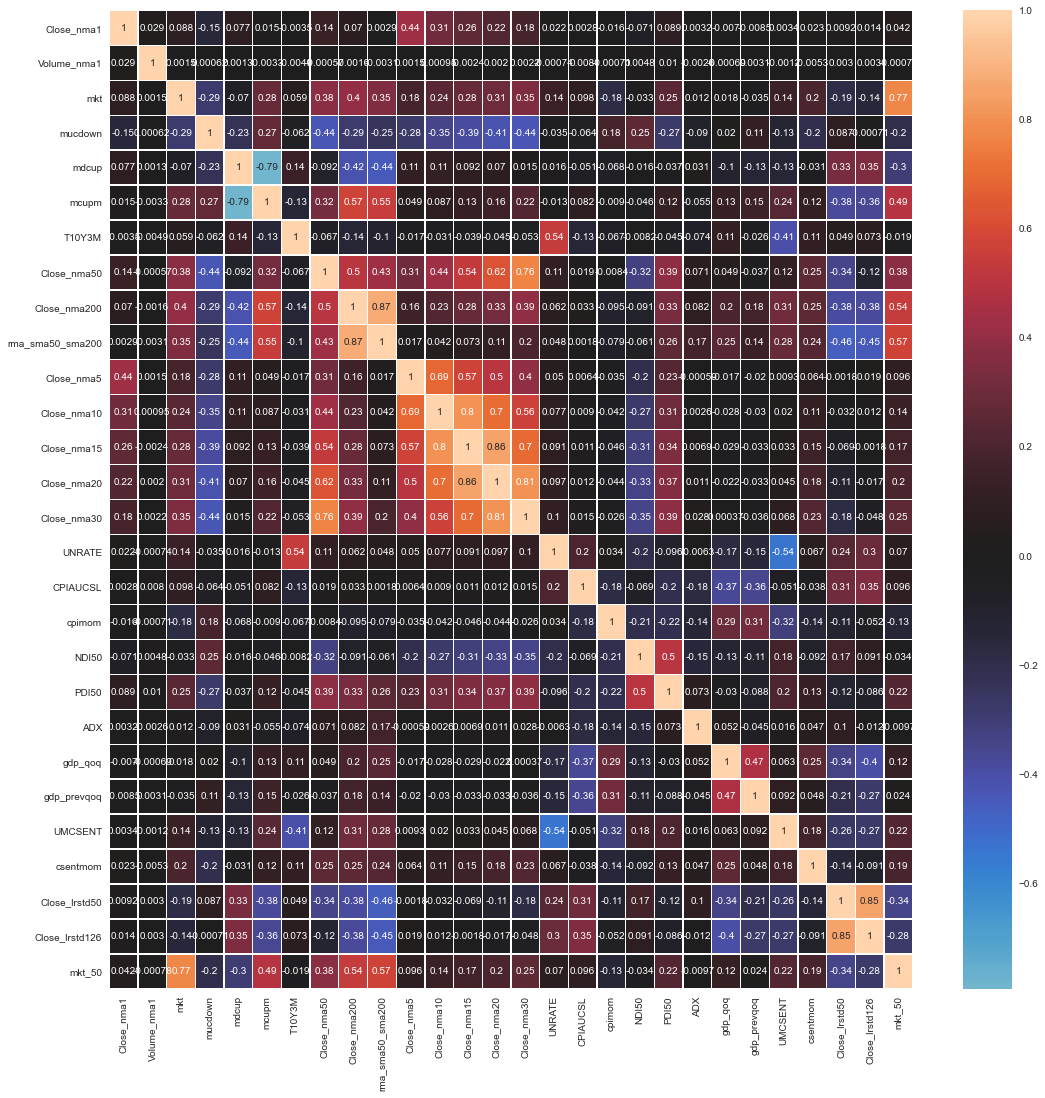

In [303]:
# ML Dataframe
cols_mkt=['Close_nma1','Volume_nma1']
cols_mcycle=['mkt', 'mucdown', 'mdcup','mcupm']
cols_ma=['T10Y3M','Close_nma50','Close_nma200','rma_sma50_sma200','Close_nma5','Close_nma10','Close_nma15',
         'Close_nma20','Close_nma30']
cols_lei=['UNRATE','CPIAUCSL','cpimom']
cols_adc=['NDI50','PDI50','ADX']
cols_lag=['gdp_qoq','gdp_prevqoq', 'UMCSENT',  'csentmom']
cols_vlty=['Close_lrstd50', 'Close_lrstd126']
cols=cols_mkt+cols_mcycle+cols_ma+cols_lei+cols_adc+cols_lag + cols_vlty

n_shift=50
mkt_n = 'mkt_' + str(n_shift)
dfmlXY = dfmc8[cols].copy()
dfmlXY['mkt'] = dfmlXY['mkt'].astype(float)
dfmlXY['mucdown'] = dfmlXY['mucdown'].astype(float)
dfmlXY['mcupm'] = dfmlXY['mcupm'].astype(float)
dfmlXY['mdcup'] = dfmlXY['mdcup'].astype(float)
dfmlXY[mkt_n]=dfmlXY['mkt'].shift(n_shift)
print(dfmlXY.columns.values)
print(dfmlXY.dtypes)

corr_matrix = dfmlXY.corr()    # this is correct one to use
#corr_matrix = dfXY_Y0Y1.corr() # this is interesting to look at
                               # but biased because Y0 and Y1 
                               # are equally sampled

fig, ax = plt.subplots(figsize=(18,18))   
#cols_corm=corr_matrix.columns
print(corr_matrix.columns.values)
print(corr_matrix[mkt_n].sort_values( ascending = False))
sns.heatmap(corr_matrix, center=0, annot=True, linewidths=.3, ax=ax)


In [199]:
# Extract X, Y Values into Numpy Arrays 
# Use Train Test Split to stratify the data set 
#   leave in mkt_n

Y=dfmlXY[mkt_n].copy().values
XY=(dfmlXY.copy()).values
X=dfmlXY.copy().drop('mkt',axis=1)
X=X.drop(mkt_n,axis=1).values

# Remove NaNs
# How many nans in Y ... these are due to n_shift
print(np.count_nonzero(np.isnan(Y)))
Y=Y[n_shift:]
X=X[n_shift:,:]
# remove first n_shift values of Y because they are null
print(np.count_nonzero(np.isnan(Y)))

# Transform Y to be 1 and 0 from +/- 1
Y = (Y + 1 )/ 2

print('Y.shape =', Y.shape)
print('X.shape =', X.shape)

# how many rows of Y = 0 and 1 are there?
print('There are', np.count_nonzero(Y == 0),'Y == 0 rows')
print('There are', np.count_nonzero(Y == 1),'Y == 1 rows')
# 

50
0
Y.shape = (17653,)
X.shape = (17653, 18)
There are 2773 Y == 0 rows
There are 14880 Y == 1 rows


In [200]:
dfmlXY.drop(mkt_n, axis=1,inplace=True)

In [201]:
# Numpy indexing example
# https://www.pythoninformer.com/python-libraries/numpy/index-and-slice/
XTest=np.array([ [[1,2,3],[4,5,6],[7,8,9]],
                 [[11,12,13],[14,15,16],[17,18,19]],
                 [[21,22,23],[24,25,26],[27,28,29]],
               ])
XTest[0,2:,1]

array([8])

In [202]:
# Sklearn stratify selects a proportional number of samples for Y = 0 
#   and 1
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, 
                            test_size=0.20, random_state=42)

In [ ]:
# sample equal number of Y=0 and Y=-1

n_shift=50
mkt_n = 'mkt_' + str(n_shift)

dfmlXY[mkt_n]=dfmlXY['mkt'].shift(n_shift)

dfXY_Y0= dfmlXY[dfmlXY[mkt_n]==1].sample(n=2800)
dfXY_Y1= dfmlXY[dfmlXY[mkt_n]==-1].sample(n=2800)

# concatonate the data frames
dfXY_Y0Y1= pd.concat([dfXY_Y0, dfXY_Y1], axis=0)


dfmlXY.drop(mkt_n, axis=1,inplace=True)

In [309]:
#fig, ax = plt.subplots(figsize=(18,18))   


corr_rma_50_200 = []
corr_nma_200 = []
corr_nma_50 = []
corr_nma_30 = []
corr_nma_20 = []
corr_nma_15 = []
corr_nma_10 = []
corr_nma_5 = []
corr_mcnr = []
corr_adx = []
corr_pdi50 = []
corr_ndi50 = []
corr_mkt = []

corr_mcupm = []
corr_mdcup = []
corr_mucdown=[]
corr_lrstd126=[]
corr_lrstd50=[]
total_corr = []

dfmlXY2 = dfmc8[cols].copy()
dfmlXY2['mkt'] = dfmlXY2['mkt'].astype(float)
dfmlXY2['mucdown'] = dfmlXY2['mucdown'].astype(float)
dfmlXY2['mdcup'] = dfmlXY2['mdcup'].astype(float)
dfmlXY2['mcupm'] = dfmlXY2['mcupm'].astype(float)

for n in range(1,201):
    mkt_n = 'mkt_' + str(n)
    dfmlXY2[mkt_n]=dfmlXY2['mkt'].shift(n)
    corr_matrix = dfmlXY2.corr()     # this is correct one to use
    corr_rma_50_200.append(corr_matrix['rma_sma50_sma200'][mkt_n])
    corr_nma_200.append(corr_matrix['Close_nma200'][mkt_n])
    corr_nma_50.append(corr_matrix['Close_nma50'][mkt_n])
    
    corr_nma_5.append(corr_matrix['Close_nma5'][mkt_n])
    corr_nma_10.append(corr_matrix['Close_nma10'][mkt_n])
    corr_nma_15.append(corr_matrix['Close_nma15'][mkt_n])
    corr_nma_20.append(corr_matrix['Close_nma20'][mkt_n])
    corr_nma_30.append(corr_matrix['Close_nma30'][mkt_n])
    
    corr_adx.append(corr_matrix['ADX'][mkt_n])
    corr_pdi50.append(corr_matrix['PDI50'][mkt_n])
    corr_ndi50.append(corr_matrix['NDI50'][mkt_n])
    
    corr_mkt.append(corr_matrix['mkt'][mkt_n])
    corr_mcupm.append(corr_matrix['mcupm'][mkt_n])
    corr_mdcup.append(corr_matrix['mdcup'][mkt_n])
    corr_mucdown.append(corr_matrix['mucdown'][mkt_n])
    
    corr_lrstd126.append(corr_matrix['Close_lrstd126'][mkt_n])
    corr_lrstd50.append(corr_matrix['Close_lrstd50'][mkt_n])
    
    total_corr.append(corr_matrix[mkt_n].abs().sum()-1)
    #print('n =', n, 'corr = ', corr_matrix['rma_sma50_sma200'][mkt_n], end = ' ...')
    print(n, end = '... ')
    dfmlXY2.drop(mkt_n, axis=1, inplace=True)
print('')

#print(corr_list)

#cols_corm=corr_matrix.columns
#print(corr_matrix.columns.values)
#print(corr_matrix[mkt_n].sort_values( ascending = False))

#sns.heatmap(corr_matrix, center=0, annot=True, linewidths=.3, ax=ax)

1... 2... 3... 4... 5... 6... 7... 8... 9... 10... 11... 12... 13... 14... 15... 16... 17... 18... 19... 20... 21... 22... 23... 24... 25... 26... 27... 28... 29... 30... 31... 32... 33... 34... 35... 36... 37... 38... 39... 40... 41... 42... 43... 44... 45... 46... 47... 48... 49... 50... 51... 52... 53... 54... 55... 56... 57... 58... 59... 60... 61... 62... 63... 64... 65... 66... 67... 68... 69... 70... 71... 72... 73... 74... 75... 76... 77... 78... 79... 80... 81... 82... 83... 84... 85... 86... 87... 88... 89... 90... 91... 92... 93... 94... 95... 96... 97... 98... 99... 100... 101... 102... 103... 104... 105... 106... 107... 108... 109... 110... 111... 112... 113... 114... 115... 116... 117... 118... 119... 120... 121... 122... 123... 124... 125... 126... 127... 128... 129... 130... 131... 132... 133... 134... 135... 136... 137... 138... 139... 140... 141... 142... 143... 144... 145... 146... 147... 148... 149... 150... 151... 152... 153... 154... 155... 156... 157... 158... 15

### Correlation Observations
* Note that the total correlation (not accounting for multi colinearity effects) 
  * Seems to have a bi-modal distribution
  * A strong positive corellation at about 10 days followed by a platau out to about 90 days
* Each average, for example nma_50_200 has maxium correlation at about 100, and nma_50 at 25 days 
* Each averaging window reaches maximum correlation at about 1/2 the window
* nma_50_200 reaches maximum at about 90 days
* nma_50 at 25 days
* nma 30 at 15 days
* and so on
* a previous "mkt" (up/down or bull/bear) correlation steadily declines to a future market condition. This makes intuitive sense.
* It's hard to say exactly when ADX reaches maximum correlation. 
  * ADX employs a 50-day EMA. 
  * We will go with 25 days since PDI and NDI reach some of there strongest negative correlation
  * It is not clear why the correlations for PDI and NDI become so strong going out to 200 days

In [311]:
# total correlation
 
dfcorr=pd.DataFrame( {'total':total_corr, 'rma_50_200':corr_rma_50_200,'nma_50':corr_nma_50,  'nma_20':corr_nma_20, 
                      'nma_30':corr_nma_30, 'nma_20':corr_nma_20,  'nma_15':corr_nma_15,
                      'nma_10':corr_nma_10,  'nma_5':corr_nma_5, 'nma_200':corr_nma_200,
                      'adx':corr_adx, 'ndi50':corr_ndi50, 'pdi50':corr_pdi50, 'mkt':corr_mkt,
                      'mcupm':corr_mcupm, 'mdcup':corr_mdcup, 'mucdown':corr_mucdown,
                      'lrstd50':corr_lrstd50, 'lrstd126':corr_lrstd126
                     })
#dfcorr['total2']=dfcorr['total']


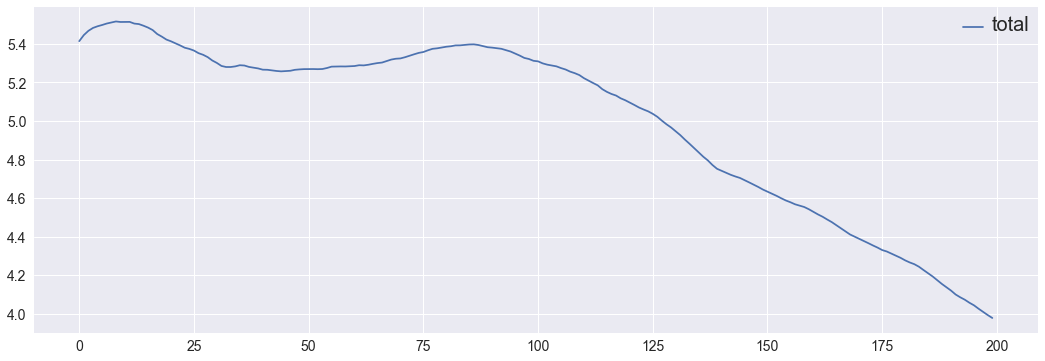

In [295]:
fig, ax = plt.subplots(nrows=1,ncols = 1,figsize=(18,6))  
dfcorr.plot(kind='line',y=['total'],ax=ax)
plt.setp(ax.get_legend().get_texts(), fontsize='20')
plt.setp(ax.get_legend().get_title(), fontsize='24') # Hue title if needed (not here)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
plt.show() 

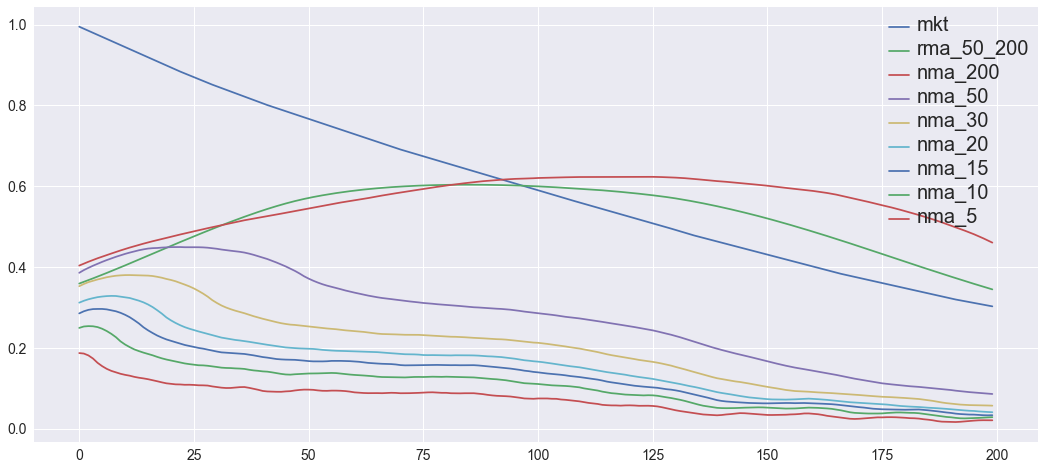

In [299]:
# moving averages
fig, ax = plt.subplots(nrows=1,ncols = 1,figsize=(18,8)) 
dfcorr.plot(kind='line',y=[ 'mkt','rma_50_200','nma_200','nma_50','nma_30'
                           ,'nma_20','nma_15','nma_10','nma_5'],ax=ax)
plt.setp(ax.get_legend().get_texts(), fontsize='20')
plt.setp(ax.get_legend().get_title(), fontsize='24') # Hue title if needed (not here)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

plt.show()


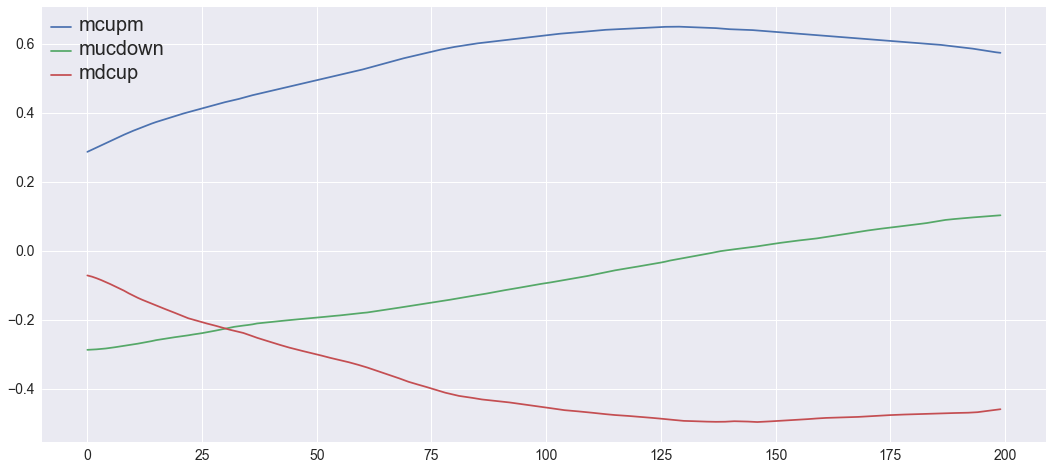

In [297]:
# Market cycle variables
fig, ax = plt.subplots(nrows=1,ncols = 1,figsize=(18,8)) 
dfcorr.plot(kind='line',y=[ 'mcupm','mucdown','mdcup'],ax=ax)
plt.setp(ax.get_legend().get_texts(), fontsize='20')
plt.setp(ax.get_legend().get_title(), fontsize='24') # Hue title if needed (not here)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

plt.show()

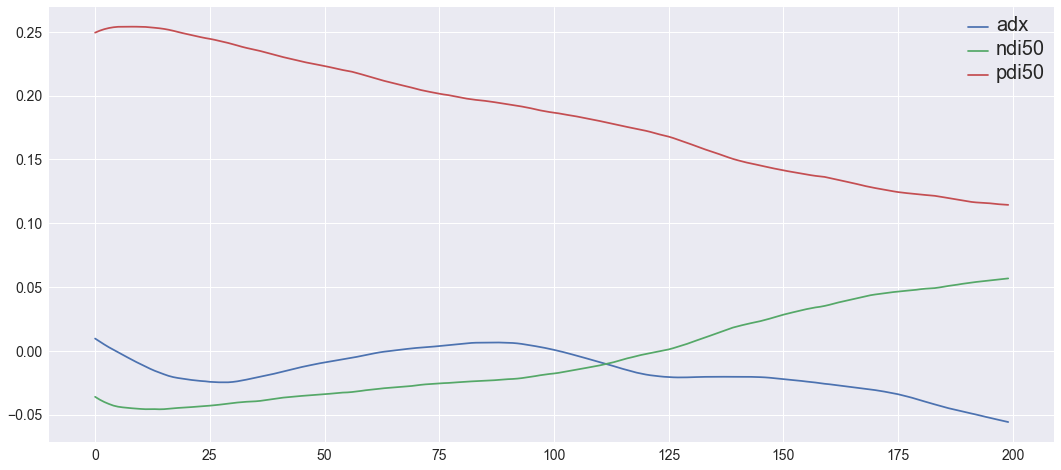

In [300]:
# ADX, PDI50, NDI50
fig, ax = plt.subplots(nrows=1,ncols = 1,figsize=(18,8)) 
dfcorr.plot(kind='line',y=['adx','ndi50','pdi50'],ax=ax)
plt.setp(ax.get_legend().get_texts(), fontsize='20')
plt.setp(ax.get_legend().get_title(), fontsize='24') # Hue title if needed (not here)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

plt.show()


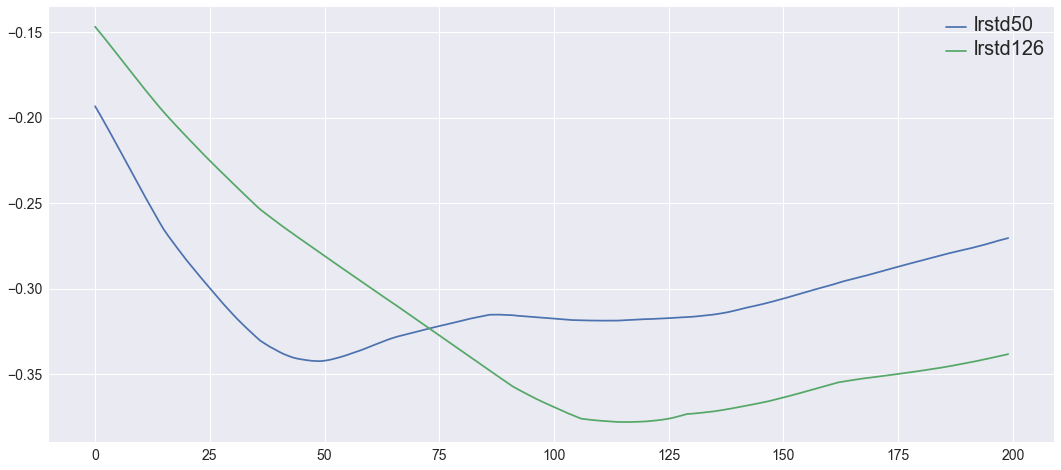

In [312]:
# lrstd50, lrstd126
fig, ax = plt.subplots(nrows=1,ncols = 1,figsize=(18,8)) 
dfcorr.plot(kind='line',y=['lrstd50','lrstd126'],ax=ax)
plt.setp(ax.get_legend().get_texts(), fontsize='20')
plt.setp(ax.get_legend().get_title(), fontsize='24') # Hue title if needed (not here)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

plt.show()

# Step 6. Save ML Data Frame

In [313]:
# Save the dfmlXY to CSV

# add some non normalized variables for conveniance ... these will be useful later
other_vars=['Close','Volume','Close_sma50','Close_sma200','mcnr']


dfmlXY2=dfmlXY.join(dfmc8[other_vars],lsuffix='l',rsuffix='r', how='outer' )

today = dt.datetime.today()
startDate=dfmlXY.index[0]
endDate=dfmlXY.index[len(dfmlXY.index)-1]
filename='./data/dfmlXY_v'+str(today.year)+str(today.month)+str(today.day)+'_'+str(startDate.year)+str(startDate.month)+\
          str(startDate.day)+'_to_'+str(endDate.year)+str(endDate.month)+str(endDate.day)+'.csv'
print('save filename =',filename)

# save the data index as a column named date 
dfmlXY2.reset_index().rename(columns={'index':'Date'}).to_csv(filename,index=False)

save filename = ./data/dfmlXY_v202091_195013_to_2020824.csv
